In [1]:
#libraries 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib.patches import Ellipse
from astroML.stats.random import bivariate_normal
from astroML.stats import fit_bivariate_normal
from astroML.resample import jackknife
from astroML.stats import sigmaG
import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats

In [2]:
M_data= np.array([5.189148323710621,5.456451853389487,5.737084161490981,5.790762689979481,5.888065021860861,5.964669994794763,6.0317637540201945,5.965407972235508,5.943840790930368,
6.055483852913131,6.099690284600123,6.215029523000862,6.378833216604002,6.831597988844853,6.88270334144654,7.037574076745823,7.090311024734824,
7.038384745731345,6.986689720221476,7.078071149671165,7.332310487291596,7.318091698137167,7.386027103610799,7.497330015091062,
8.257298746642654,8.683167503671624,9.546422661178557,10.151266164056729,10.71414363598026])#and this is in log units i.e 10^(M_data)Solar M

Z_data= np.array([7.555416715578969,7.710564730437598,7.770089461292543,7.813804219079663,7.764507679027072,7.683109824319121,7.748052827915152,
7.841131028692265,7.957604120542158,8.024829276291836,7.830018005043833,8.058568515540001,8.103819775392811,7.984875150832128,8.024172681533493,
8.001557775189031,8.05789004927978,8.154671017794406,8.223697505793018,8.229404453965968,8.269758332760778,8.154467945526626,8.103060626768919,
8.252242520450855,8.32154228501783,8.576300340850914,8.77061488396522,9.051756845779114,9.27660201615495] )#Funky Units 12+log(Z_data/Z_Stellar)
Z_err = np.full_like(Z_data, 0.1)


In [55]:
def Z_model(M):
    Z0=8.8#add errorbars
    gamma =0.513
    m0=10 # 8.8 + 0.35[log(M*/M⊙) - 10]
    return 1.7/5.6*(M)+6 #chose a siimple linear model

# Chi-Squared for Original Data ---
print(Z_model(M_data))
chi2 = np.sum(((Z_data - Z_model(M_data)) / Z_err) ** 2)
dof = len(M_data) - 1  # Degrees of freedom
reduced_chi2 = chi2 / dof

print(f"Chi-squared: {chi2:.2f}")
print(f"Reduced Chi-squared: {reduced_chi2:.2f}")


'''
Chi^2 values are close to the 29 input values so that is good
chose this technique because it HUBER method seems like it would be good
if there was a obvious outlier... Which is not this case. We know gernerally 
that there is a one to one 

NEED TO GET CITATIONS 
'''

[7.57527717 7.65642288 7.74161483 7.7579101  7.78744831 7.81070339
 7.83107114 7.81092742 7.80438024 7.83827188 7.85169169 7.88670539
 7.93643151 8.07387796 8.08939209 8.13640642 8.15241585 8.13665251
 8.12095938 8.14870017 8.22587997 8.22156355 8.2421868  8.27597518
 8.50667998 8.63596156 8.89802117 9.08163437 9.25250789]
Chi-squared: 28.68
Reduced Chi-squared: 1.02


'\nChi^2 values are close to the 29 input values so that is good\nchose this technique because it HUBER method seems like it would be good\nif there was a obvious outlier... Which is not this case. We know gernerally \nthat there is a one to one \n\nNEED TO GET CITATIONS \n'

<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\c'
/var/folders/9_/5x2g4jmx5fxb62v465flw5980000gp/T/ipykernel_68973/1810749503.py:15: SyntaxWarning: invalid escape sequence '\c'
  plt.axvline(chi2, color='r', linestyle='--', label=f'Original $\chi^2$ = {chi2:.2f}')


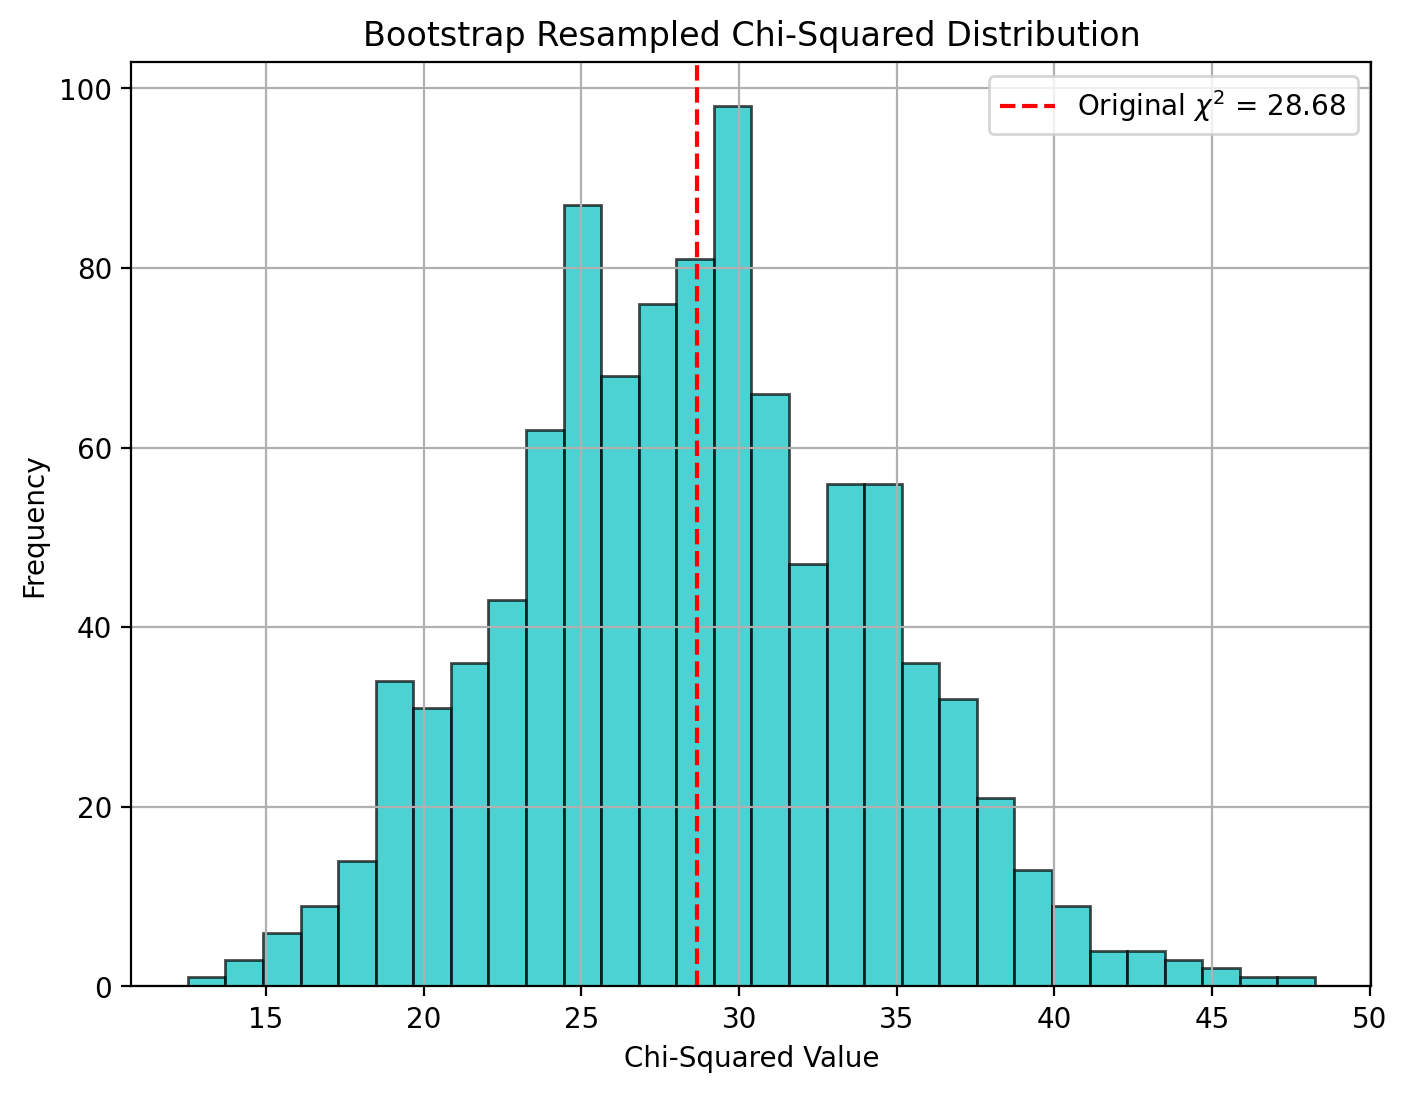

In [143]:

n_boot = 1000  # Number of bootstrap iterations
chi2_boot = np.zeros(n_boot)

for i in range(n_boot):
    resample_idx = np.random.choice(len(M_data), size=len(M_data), replace=True)
    M_boot = M_data[resample_idx]
    Z_boot = Z_data[resample_idx]
    Z_err_boot = Z_err[resample_idx]
    
    chi2_boot[i] = np.sum(((Z_boot - Z_model(M_boot)) / Z_err_boot) ** 2)

# ---- Plotting Chi-Squared Distribution ----
plt.figure(figsize=(8, 6))
plt.hist(chi2_boot, bins=30, color='c', edgecolor='k', alpha=0.7)
plt.axvline(chi2, color='r', linestyle='--', label=f'Original $\chi^2$ = {chi2:.2f}')
plt.xlabel('Chi-Squared Value')
plt.ylabel('Frequency')
plt.title('Bootstrap Resampled Chi-Squared Distribution')
plt.legend()
plt.grid(True)
plt.show()
'''
this figure shows a relatively gaussian distribution, showing that the chi2 
fitting is relatively accurate


'''

In [7]:
from scipy.optimize import curve_fit


def Z_model(M, a, b):  # Explicit parameters
    return a * M + b
params, covariance = curve_fit(Z_model, M_data, Z_data, sigma=Z_err, absolute_sigma=True)

# Extract best-fit values and uncertainties
a_fit, b_fit = params
a_err, b_err = np.sqrt(np.diag(covariance))
print(a_err)

0.013848996960948275


<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/var/folders/9_/5x2g4jmx5fxb62v465flw5980000gp/T/ipykernel_98733/1618583998.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.fill_between(M_fit, Z_lower, Z_upper, color='r', alpha=0.3, label="1$\sigma$ Confidence Band")


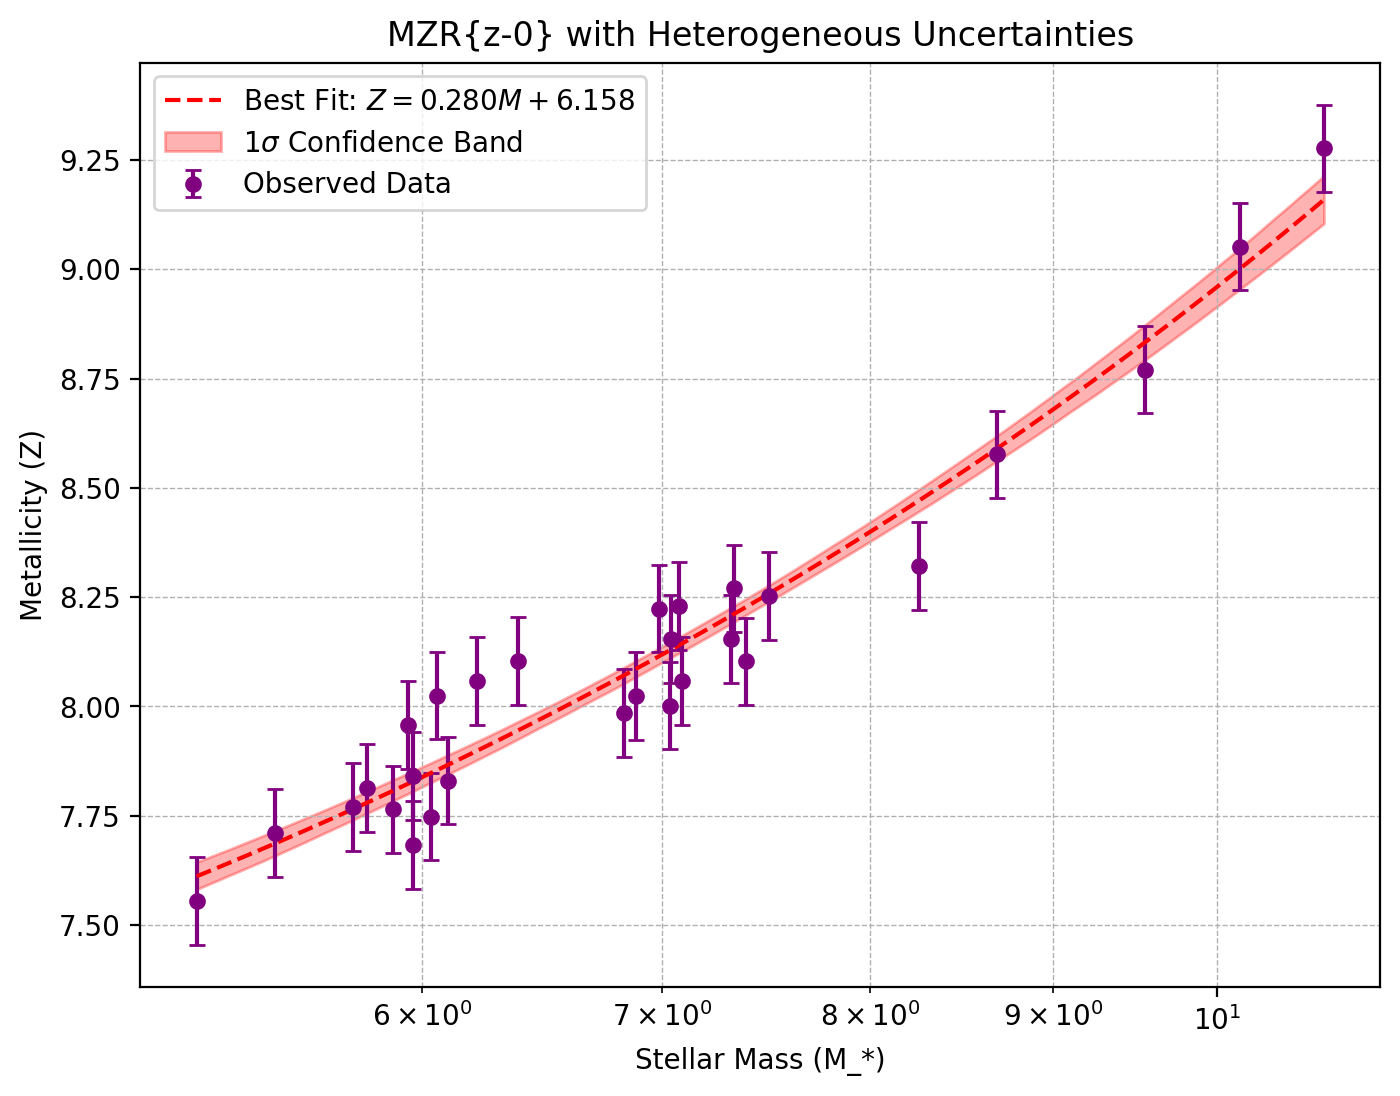

'\nUsed MCMC to estimated the hetergeneous unsertain\n'

In [13]:
M_fit = np.linspace(min(M_data), max(M_data), 100)  # 100 points for smooth curve
Z_fit = Z_model(M_fit, a_fit, b_fit)  # Best-fit metallicity values

# Monte Carlo Sampling to get confidence intervals
n_samples = 1000  # Number of Monte Carlo samples
param_samples = np.random.multivariate_normal([a_fit, b_fit], covariance, size=n_samples)

Z_samples = np.array([Z_model(M_fit, a, b) for a, b in param_samples])
Z_lower = np.percentile(Z_samples, 16, axis=0)  # 1-sigma lower bound
Z_upper = np.percentile(Z_samples, 84, axis=0)  # 1-sigma upper bound

# Plot the observed data with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(M_data, Z_data, yerr=Z_err, fmt='o', label="Observed Data", color='purple', capsize=3, markersize=5)

# Plot the best-fit model
plt.plot(M_fit, Z_fit, label=f"Best Fit: $Z = {a_fit:.3f} M + {b_fit:.3f}$", color='r', linestyle='--')

# Confidence band
plt.fill_between(M_fit, Z_lower, Z_upper, color='r', alpha=0.3, label="1$\sigma$ Confidence Band")

# Labels and grid
plt.xscale('log')  
plt.xlabel('Stellar Mass (M_*)')
plt.ylabel('Metallicity (Z)')
plt.title("MZR{z-0} with Heterogeneous Uncertainties")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

'''
Used MCMC to estimated the hetergeneous unsertain
'''

In [49]:
mZ0=np.array([5.732236209821023,5.9444518224245416,4.63900062926022,7.417437670941506,7.536631773761349 ,7.612449530399777,
              8.552916006889259,8.446592568635413,8.83936800844711,9.650501711008378 ,10.174923417349447,9.80456344899926
              ,10.640466443865007 ])
zZ0=np.array([7.362394426680545,7.671595744887809, 7.837249152397264,7.70289938151926,7.971667760848821, 8.116491698829535, 8.34858209461156,
  8.478593858793166,  8.262817848060557, 8.492043659573536, 8.742913609818558, 8.856459094024766, 8.985837251007021])


mZ1=np.array([5.914920874890904 ,6.42669840488378 ,7.011789163578599,7.339226451192587,
7.477545400817021,8.007394350482551 ,7.826732623497911, 8.175248495057716 ,8.175248495057716 ,8.329323559000095 ,
8.09088614510896  ,8.381324516637095  ,8.433650122437422,8.610439607878796,8.790935023932521 ,8.809191368605367,
8.736392685324617, 9.531759497718994, 9.671189596167467,9.531759497718994,9.297397127899965 ,8.975214055771275 
,9.472620799430548 ,10.270891893462329,10.143838145781896 ,10.421133983414533 ])

zZ1=np.array([ 7.4624721865397055,7.728081382223848, 7.39908643559986, 7.597355303364859,  7.754495294053686, 7.969082738522885,
 7.747883364333574, 8.02365110151417, 8.016809674036278, 7.941937883720869,8.154753215150043,8.106205052395525,
  8.22461253640144,  8.273869843048532, 8.252723548647088,  8.337634386101605,  8.430607278171198,  8.47386681656394,
  8.495579755494392,  8.561052958645538, 8.330525238374715, 8.147800002452268, 8.835564367791198,  8.934089672967678, 9.064590082619503,
 9.041422871368711])

mZ2=np.array([5.807350449677521 ,6.2315467682826595 ,6.803039163224746 , 7.106911017279848 ,7.106168288124999 ,7.210490671923489 ,7.135565194283377 ,
7.165000505187001, 7.017194538676675 ,6.987717250251798, 7.031224469772595,7.255047924759732, 7.4397182823179975 , 7.856556237882417 ,
7.2088999279406885, 7.345416641867537 ,7.330121337982069, 7.330291583615599 ,7.484692438023597 , 7.484822814361978, 7.579197701380149,
7.674272379254724 ,7.4532945965282416,7.562449517904272 ,7.56231778940491 ,7.60957934308619,7.530463140536694,7.530463140536694, 7.468239813434249,
7.641724291484299, 7.737673167031918, 7.70561674623249, 7.689794643667249,7.83555466495209,7.901618266610906 , 8.01775794459652,8.324398449672318 ,8.53475175511403 ,8.341138819947373 ,8.322851905688651,
8.218835385047425 , 8.133620922936386 ,8.184452899663297 , 8.150166926685666,8.08258840718454,7.704990395524621 , 7.6409256700563954 ,
7.641058767831481 ,7.785397736678098 ,7.721247240689713,7.884020279850638 , 7.818875551883681,8.08432500248947  ,7.9837530674686,
8.06683530983115,7.999483261036838 ,7.8835167487122915,7.899691575182719,7.736190708689184,7.736190708689184,8.479626761373389,8.3047979617181,8.270728148246452 ,8.150924119429238 ,
8.515447028485424,8.427255101793037,8.48031608348176 ,8.676655767288603 ,8.87779891857183,8.766795932857288,8.33891128273557 ,
8.304171122995783 , 8.235506920261475,8.821072814675889,9.025092223020355,9.234420100137998 ,9.19578904120457 ,9.234527336464625,
9.389647168403448 ,9.646726589590916,9.828324709171701 ,9.250519473343104 ,8.25106239653967  ,8.566874375517404 ,8.532125724862194,
8.532422970743223])

zZ2= np.array([ 7.409447747029659,7.823474021416112, 7.599796786444932, 7.683978428146436, 7.802538690020461, 7.822364925829585, 7.849106152887684
,  7.909396372048876, 7.90955656736595, 7.956827200623948,  8.01111104476598,  7.929510193113506,7.788928436303535,7.432519020507999
,  8.079351936292165,  8.079221028628197, 8.051777358351835,  8.031093139282916, 8.024199379678613
 , 8.003715687856504, 8.017262823903925, 8.05141859601775,  8.092846792540731, 8.15492663819914, 8.17576420230567, 8.203580623476526,
  8.2386302778088,8.189785006473064, 8.147910079473235,   8.1617178101867,  8.127094126141754, 8.10623284376867,
 8.037504441594516,   8.023435577352526, 8.09178145270513, 8.112638406564276, 8.175068759763219,8.244839878129318,
 8.329533884392164,8.329618236313763,8.357958115415023,  8.393616344452346,  8.379416295284793, 8.25949770743105, 8.273628593883663,
 8.252541602875528,8.30874192897271,  8.23142499787776,  8.203431088054797, 8.210279281804418, 8.16160209812959,8.119789044386806,
  8.133713855481508, 8.217083264611047, 8.273259946543634,  8.287464733459256, 8.329854426238715,  8.415421732987252,  8.415489910274024,
  8.36478283114632,  8.350733040378014, 8.280032271754832, 8.280149662869418,  8.30801834840976,  8.29397990944094, 8.265756518085547, 8.314937010463145,
  8.32890970672062,8.421628128444064, 8.43637812519349, 8.44359179360263,  8.400674347142994, 8.522470048133927, 8.478962771425733,
 8.450161249873092, 8.602398774044199,8.631561842268882,  8.587584615373949, 8.609388214247833,  8.719716226546328,
 8.861631000639633, 9.044937334825843,8.64716989345196, 8.595519461600109,  8.464944076171212,  8.421849870060058])



mZ3=np.array([4.3201462482795465,5.336042071547728 ,5.681542408026005 ,6.574479585192804 , 6.574479585192804 ,6.639900349800481 ,
6.785204866489623,6.917226201337884,7.017761686389618 ,7.102475252897441,7.102759019353795 ,7.1195687300633566 ,7.034885497126287 ,
7.051957176331243,7.257902545409424 , 7.188594348071478 ,7.223670355669965 ,7.171812682024585,7.34566166318336,7.275418533231441 ,
7.345368192382219 ,7.345368192382219 ,7.416138528661969,7.505461114927218 , 7.469265489681237,7.433590900282679 ,7.362850126740693 ,7.309701256068125,7.452076703751147 ,
7.523875143324797 ,7.559882337259981 ,7.632922750135498 ,7.651445696761954  ,7.799646490352436 ,7.950664842482122,
8.008420836181953 ,7.6518023474478145 ,7.725627966489108 ,7.725370756419516, 7.506110841950741 ,7.6150023929118476,7.346248639961385 ,
7.363683636836099 ,7.346493227461908 ,7.453069197162842 ,7.346101891369765 ,7.506910583192378 ,7.597478227226521,7.543740706410488,7.597984139627637 ,7.5612416182478634,7.707643926436398 ,7.725885185122307,7.781541961896585,7.837547498202103 ,7.856723957111487,
7.951353109561792 ,7.9324738670497705,7.951617843533939,7.951988485902713 ,8.164405665362066 , 8.203860644073323 ,8.243341619127337 ,
8.322541976688608 ,8.3219878195441 ,8.463147071821648 ,8.524058275913427 ,8.301565201895054 ,7.577017059234829 ,7.9299917060197,
7.94791236987409  ,7.833477882381929,7.342678589647188,7.290160743545428 ,7.20330451932541 ,7.186871345890217 ,7.274062198353325,7.239368140708834,7.18730205771491,7.101813175253188,7.10200233399645,
8.751523747886027,8.12367978538572 ,7.416928683771579 ,7.971763436973576 ,8.145562935907888 ,8.04878327231053,8.16538428631273 ,8.087464087065857,
8.383390146486406, 8.587065901406781,8.648926568316634,8.794811512173286 ,8.901984028798644 ,8.96605364278483 ,9.683601270987088 
])


zZ3= np.array([  4.386268578648442,4.765270056165627,5.478737609469011,5.027643960203617, 5.5890027562828335,  5.7289432695588935, 5.912237514424316,
 6.006008077747032, 6.032965998431215,6.115057536383185, 6.046538713046658,6.087700299673673,  6.142767232058287, 6.184022706615588, 6.170240187062857
 ,6.324970369005317, 6.296640424269418, 6.253899188842507,6.211912275977306,6.169943772306504,6.169812036985567,6.1419147741515285,  6.059527380687237, 6.073257105462222, 6.128356949223936,  6.019006065603245, 6.253698898114691,
 6.253565374526504, 6.211381767383045, 6.183329549474049, 6.267467108431315,6.324160140363467, 6.33815114263495, 6.33788049204491,
 6.438505033605774,6.4246697289842745,6.453541257131885, 6.381263807727582,6.324430205044508, 6.367109663813192,6.425252751202853,
 6.3675854943017525,6.498028441822718,6.541879401983416,6.381979153488306,6.556527052914501, 6.571137349039923, 6.78177529785077,
6.72083646715167,  6.60087848456936,6.600596615043611, 6.526637357801799, 6.497196044443449,6.4533345725601725,  6.555862130293073,
 6.526219313322935,  6.570506016958169, 6.600138602735305,6.705034304469243,6.689554952314356,6.750029993479288,6.765179817130602,
 6.704354321156351,6.555022324418879, 6.6439693108797755, 6.5991169974927235, 6.423503843251207, 5.937728530966288,  5.9104389486109365,
5.637331480369042, 5.413504120356573, 5.450996434242831,5.475697011697786,5.475843155661346,5.689630329266827, 5.832214935275932, 5.858611689081753,
  5.806154057810495, 5.845679234868355,5.89858842594044,  6.524826025103673, 6.23842895710947, 6.396234636225021,6.904246751544238,
 6.888381032046575,  6.966588280087075, 6.966365164396388,  6.966513907396209,  6.919040942857408,  6.997036029790741, 6.965472773087579,
 6.840819713366248, 7.107860187791531,7.139763763127482,7.091564425227333,7.7939131222954146
])


<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
/var/folders/9_/5x2g4jmx5fxb62v465flw5980000gp/T/ipykernel_98733/4048535675.py:11: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Stellar Mass (log M$_*$/M$_\odot$)", fontsize=13)


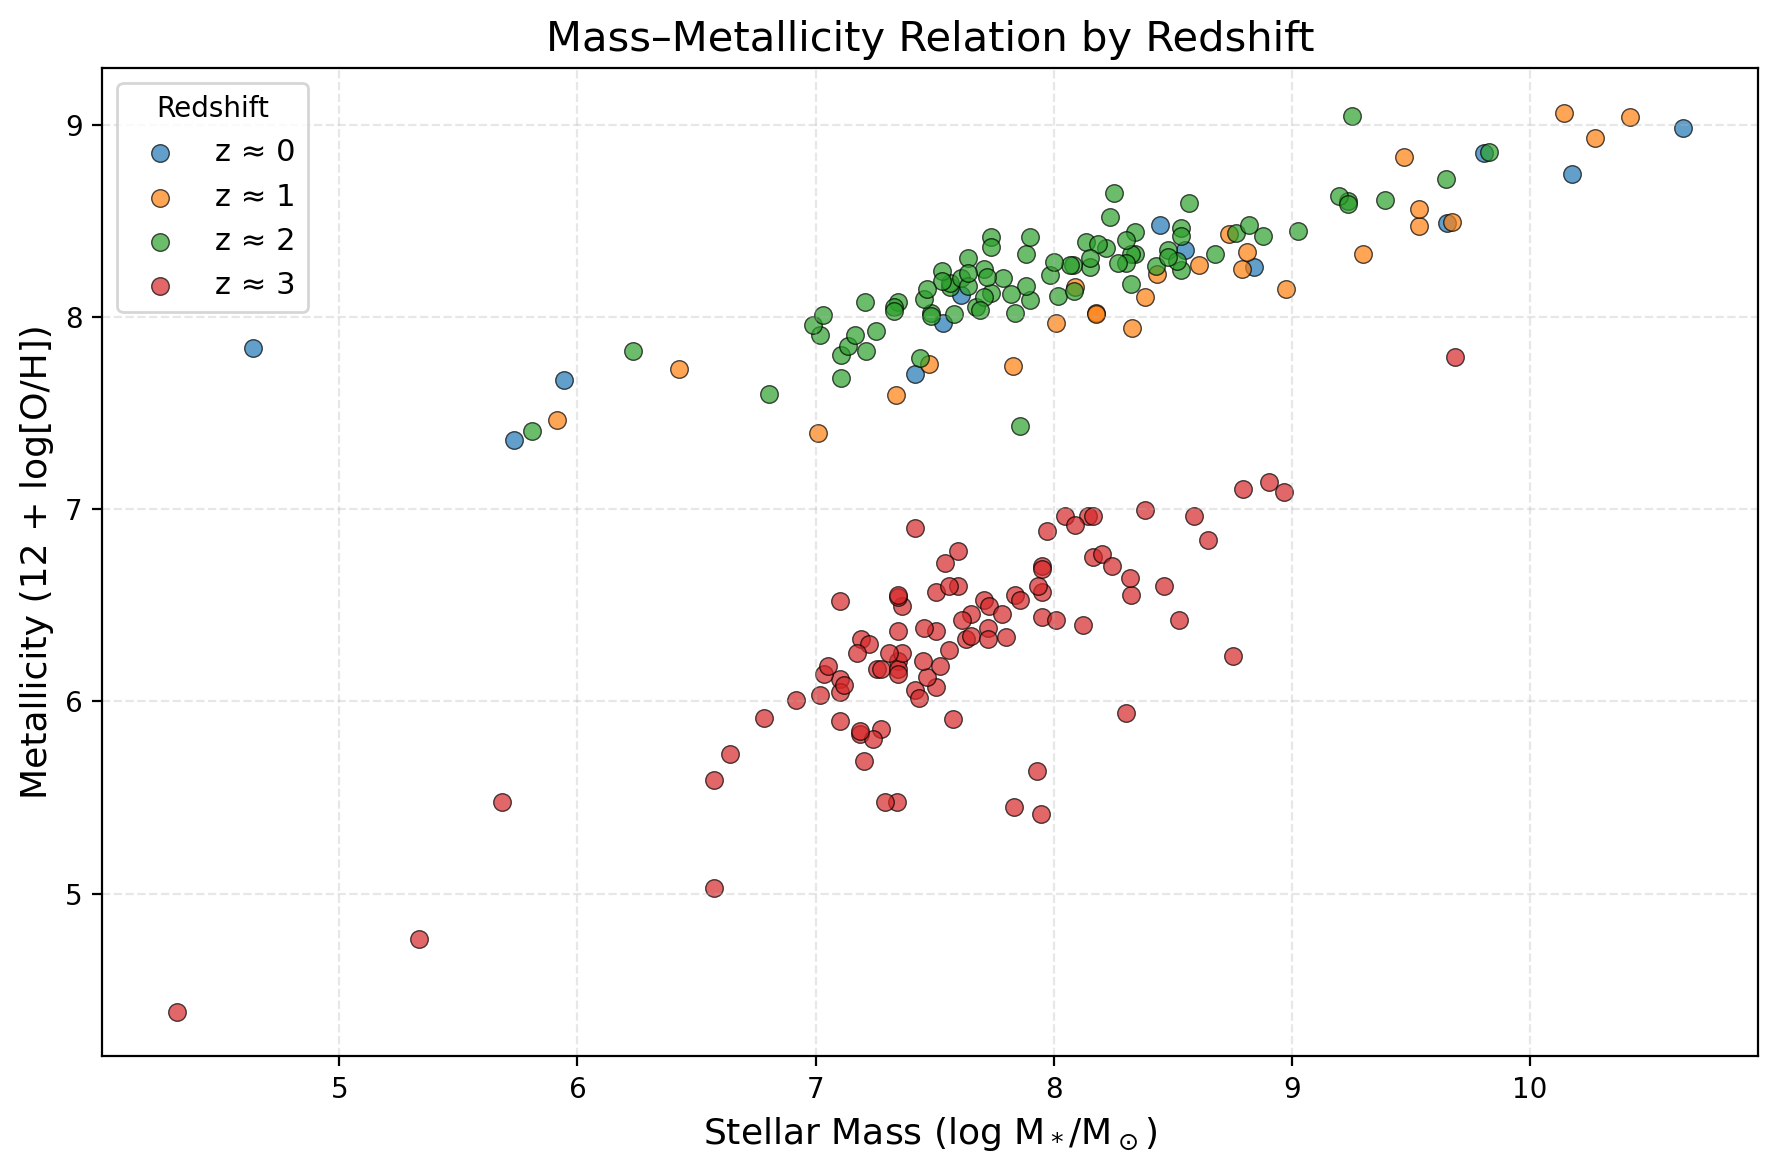

In [45]:
plt.figure(figsize=(9, 6))

# Use consistent colors from a pleasant palette (e.g., Set1 or tab10)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plt.scatter(mZ0, zZ0, label="z ≈ 0", color=colors[0], s=40, alpha=0.7, edgecolor='k', linewidth=0.5)
plt.scatter(mZ1, zZ1, label="z ≈ 1", color=colors[1], s=40, alpha=0.7, edgecolor='k', linewidth=0.5)
plt.scatter(mZ2, zZ2, label="z ≈ 2", color=colors[2], s=40, alpha=0.7, edgecolor='k', linewidth=0.5)
plt.scatter(mZ3, zZ3, label="z ≈ 3", color=colors[3], s=40, alpha=0.7, edgecolor='k', linewidth=0.5)

plt.xlabel("Stellar Mass (log M$_*$/M$_\odot$)", fontsize=13)
plt.ylabel("Metallicity (12 + log[O/H])", fontsize=13)
plt.title("Mass–Metallicity Relation by Redshift", fontsize=15)

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title="Redshift", fontsize=11)
plt.tight_layout()
plt.show()


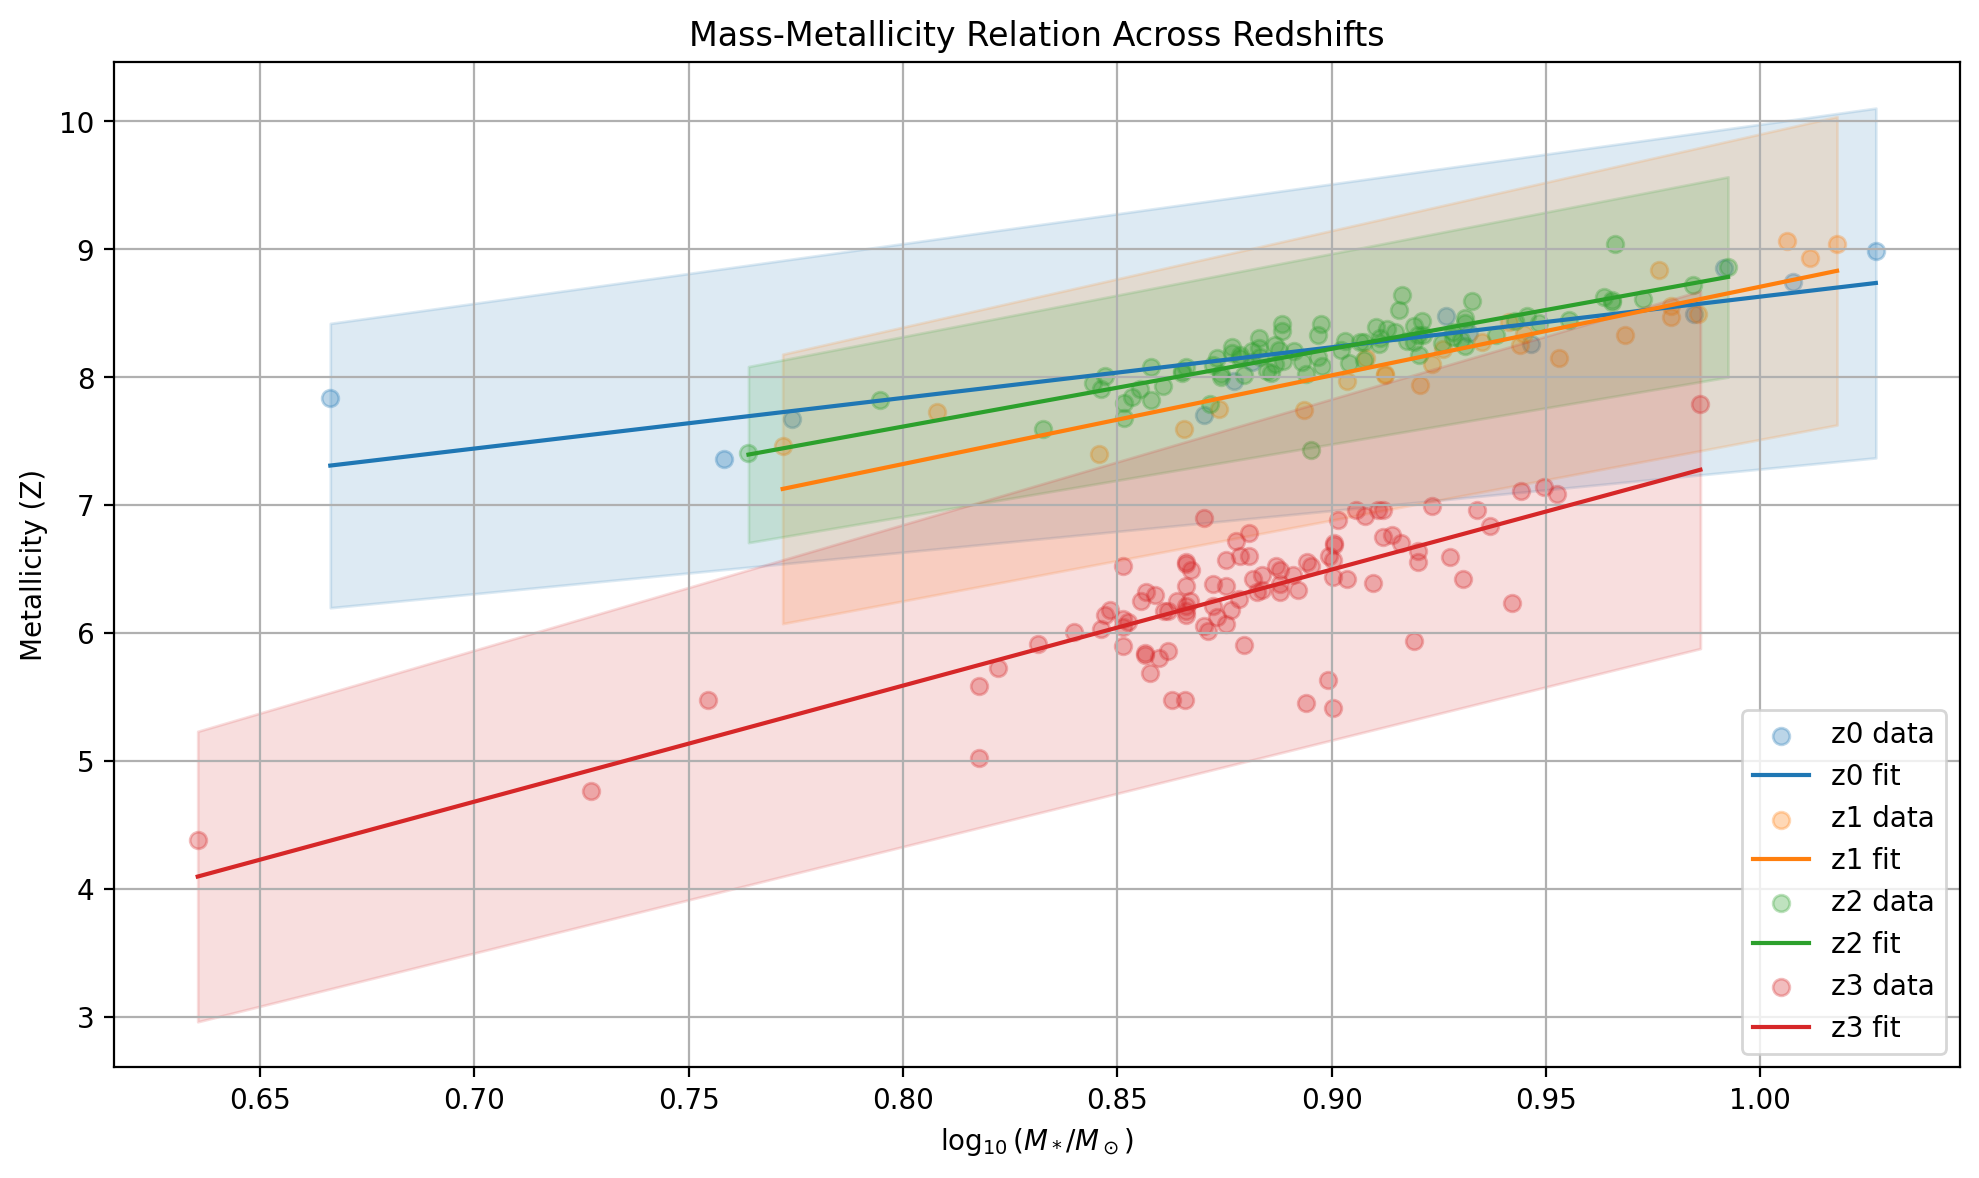

In [53]:
redshift_bins = {
    'z0': (mZ0, zZ0),
    'z1': (mZ1, zZ1),
    'z2': (mZ2, zZ2),
    'z3': (mZ3, zZ3),
}
def linear_model(x, a, b):
    return a * x + b #this is the same as Zmodel

plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for i, (label, (masses, metallicities)) in enumerate(redshift_bins.items()):
    logM = np.log10(masses)
    Z = metallicities

    # Fit the model
    popt, pcov = curve_fit(linear_model, logM, Z)
    a, b = popt
    perr = np.sqrt(np.diag(pcov))

    # Generate line and error band
    x_fit = np.linspace(min(logM), max(logM), 100)
    y_fit = linear_model(x_fit, *popt)

    # 1-sigma confidence interval
    y_upper = linear_model(x_fit, *(popt + perr))
    y_lower = linear_model(x_fit, *(popt - perr))

    # Plot the data and fit
    plt.scatter(logM, Z, alpha=0.3, color=colors[i], label=f'{label} data')
    plt.plot(x_fit, y_fit, color=colors[i], label=f'{label} fit')
    plt.fill_between(x_fit, y_lower, y_upper, color=colors[i], alpha=0.15)

# Labels and legend
plt.xlabel(r'$\log_{10}(M_*/M_\odot)$')
plt.ylabel(r'Metallicity (Z)')
plt.title('Mass-Metallicity Relation Across Redshifts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\o'
<>:34: SyntaxWarning: invalid escape sequence '\o'
<>:26: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\o'
<>:34: SyntaxWarning: invalid escape sequence '\o'
/var/folders/9_/5x2g4jmx5fxb62v465flw5980000gp/T/ipykernel_98733/3613379210.py:26: SyntaxWarning: invalid escape sequence '\c'
  ax[0].set_title(f"Bootstrap Histogram of $\chi^2$ at {z_key}")
/var/folders/9_/5x2g4jmx5fxb62v465flw5980000gp/T/ipykernel_98733/3613379210.py:27: SyntaxWarning: invalid escape sequence '\c'
  ax[0].set_xlabel("$\chi^2$")
/var/folders/9_/5x2g4jmx5fxb62v465flw5980000gp/T/ipykernel_98733/3613379210.py:33: SyntaxWarning: invalid escape sequence '\o'
  ax[1].set_xlabel("Mass (log M/M$_\odot$)")
/var/folders/9_/5x2g4jmx5fxb62v465flw5980000gp/T/ipykernel_98733/36133

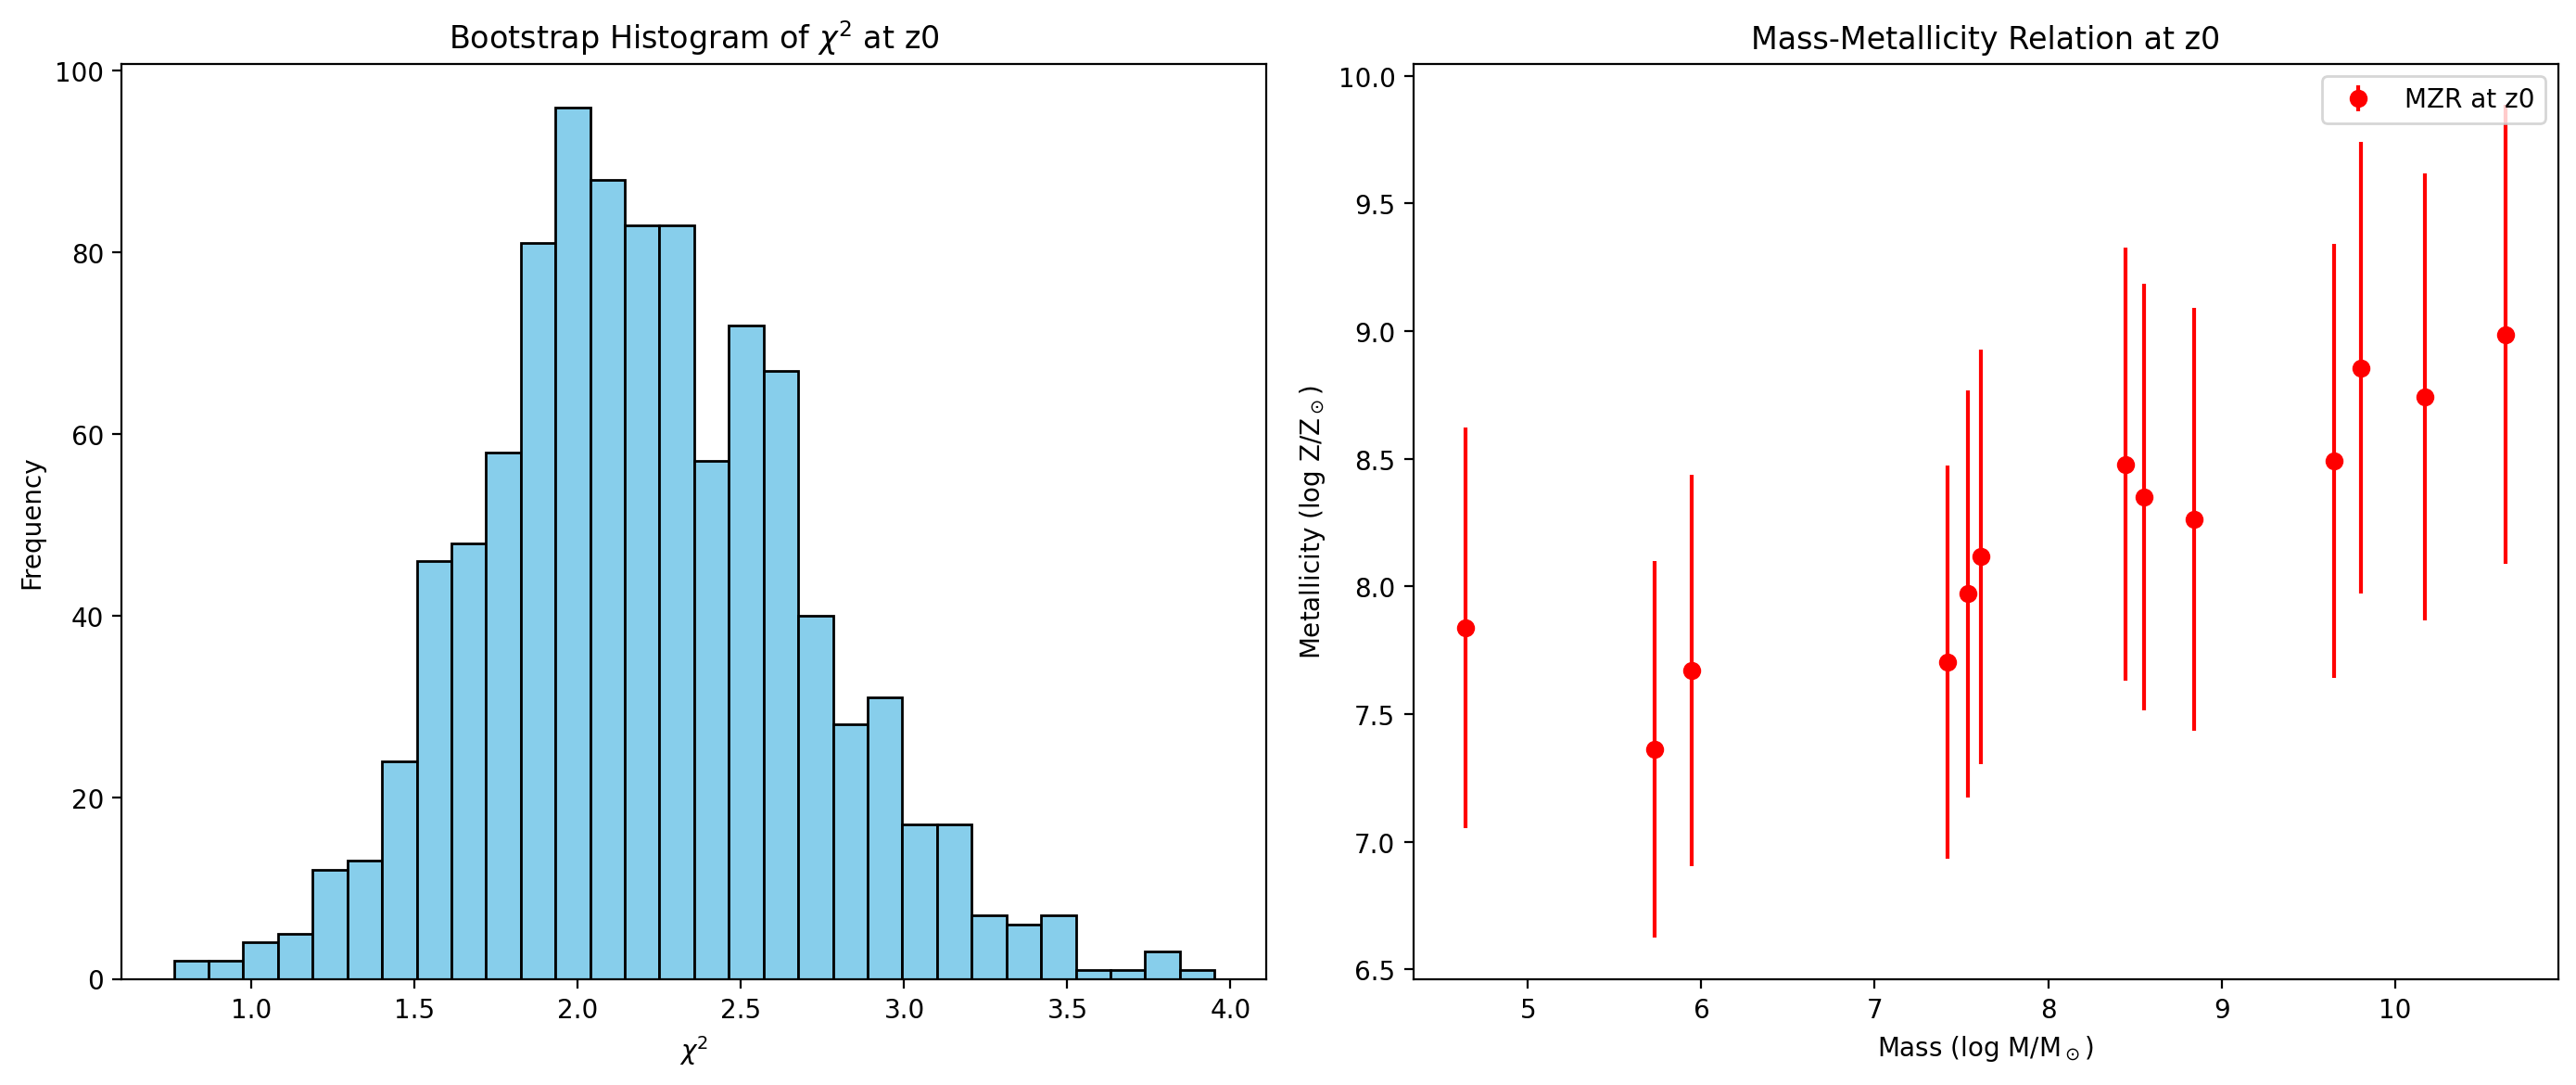

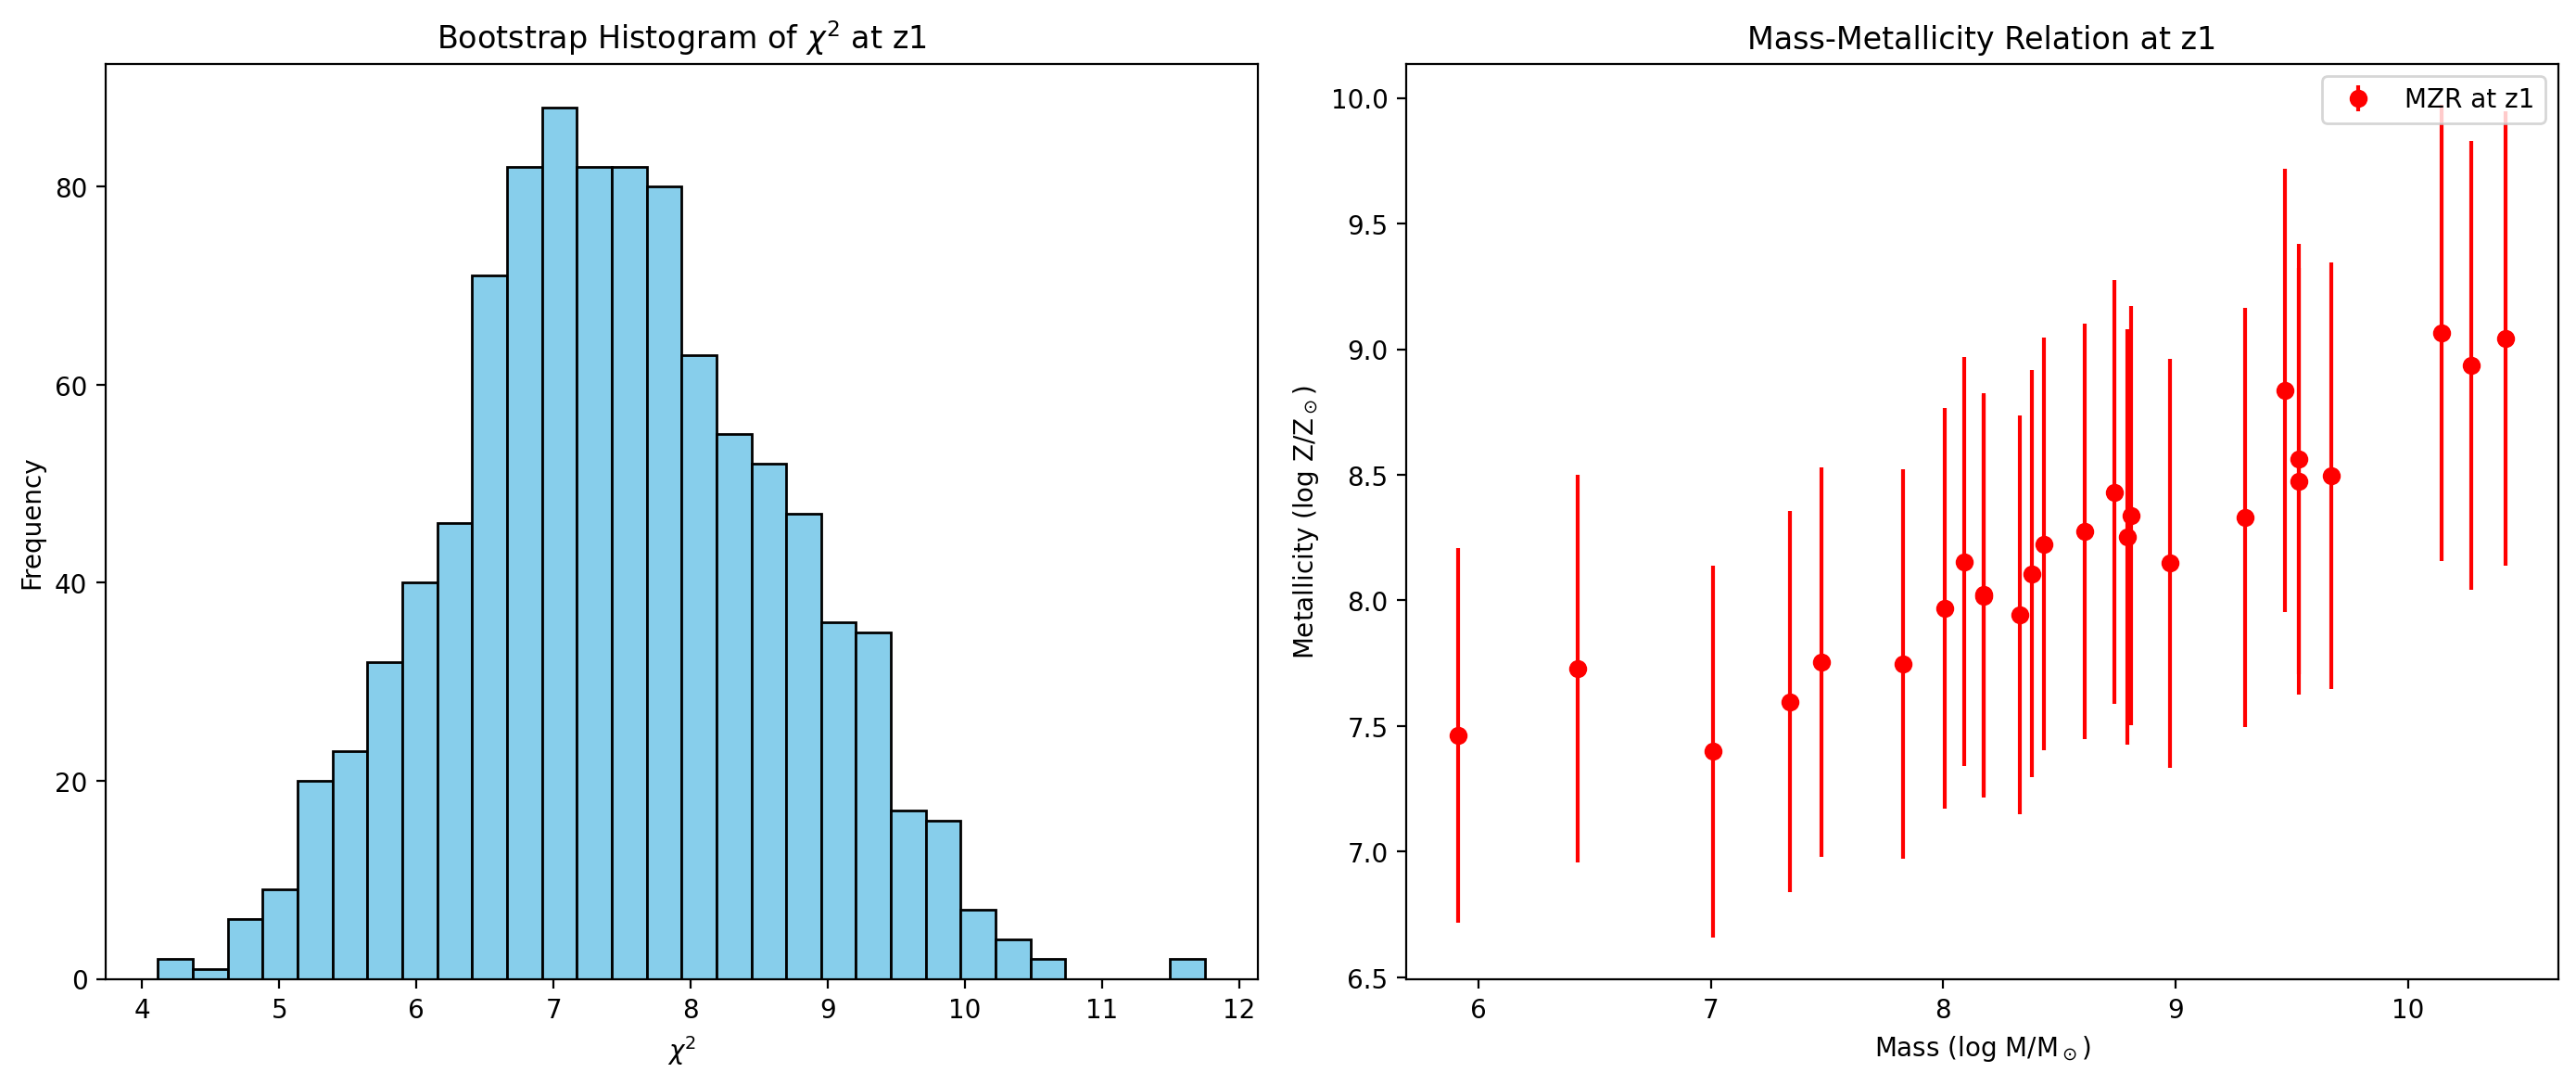

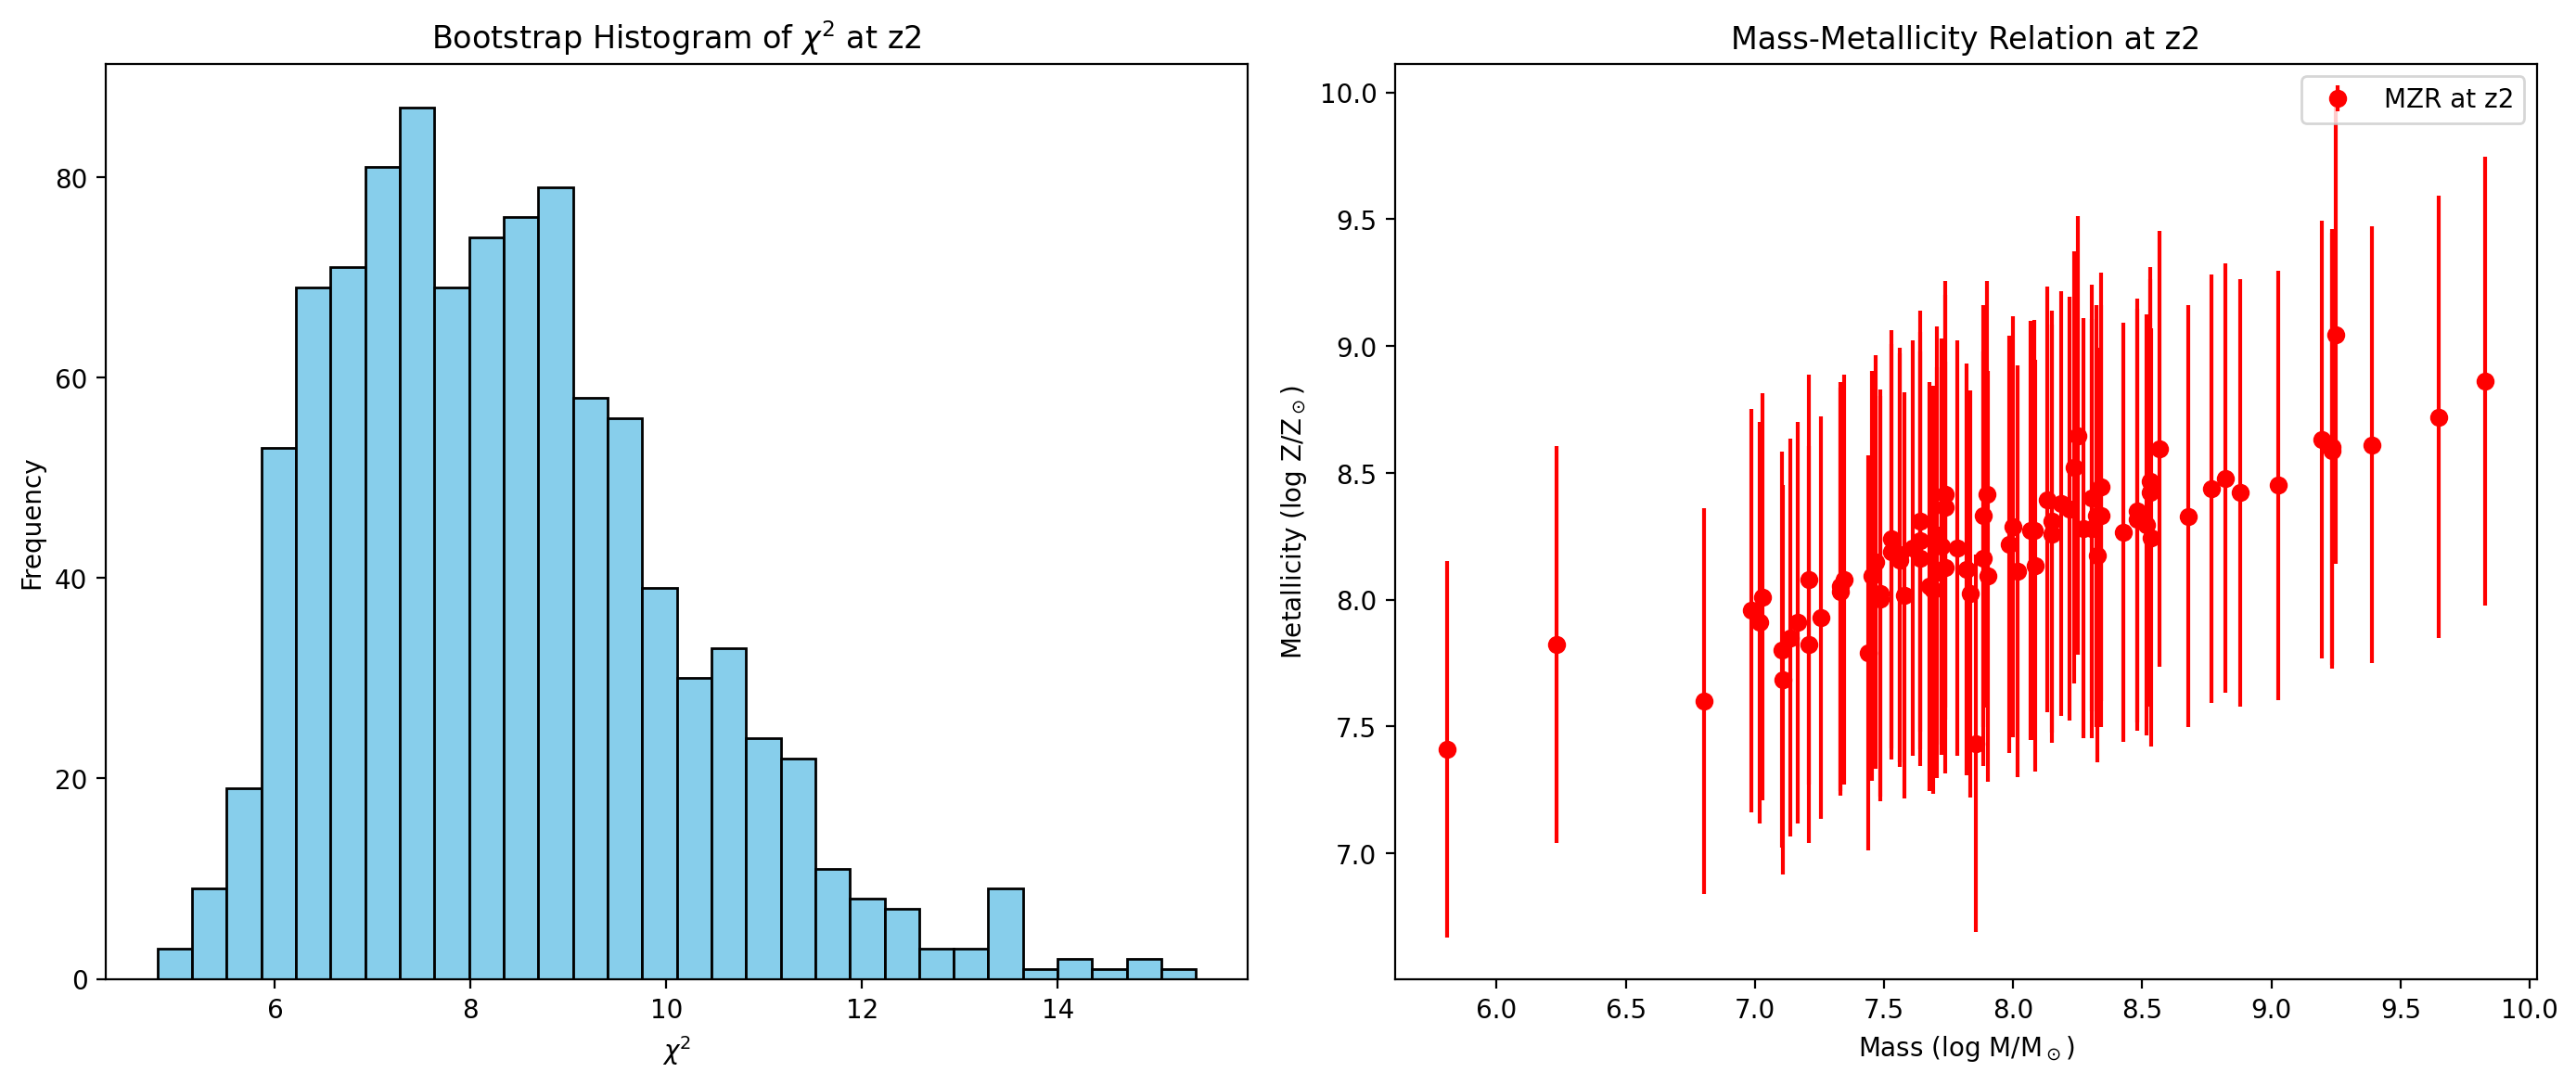

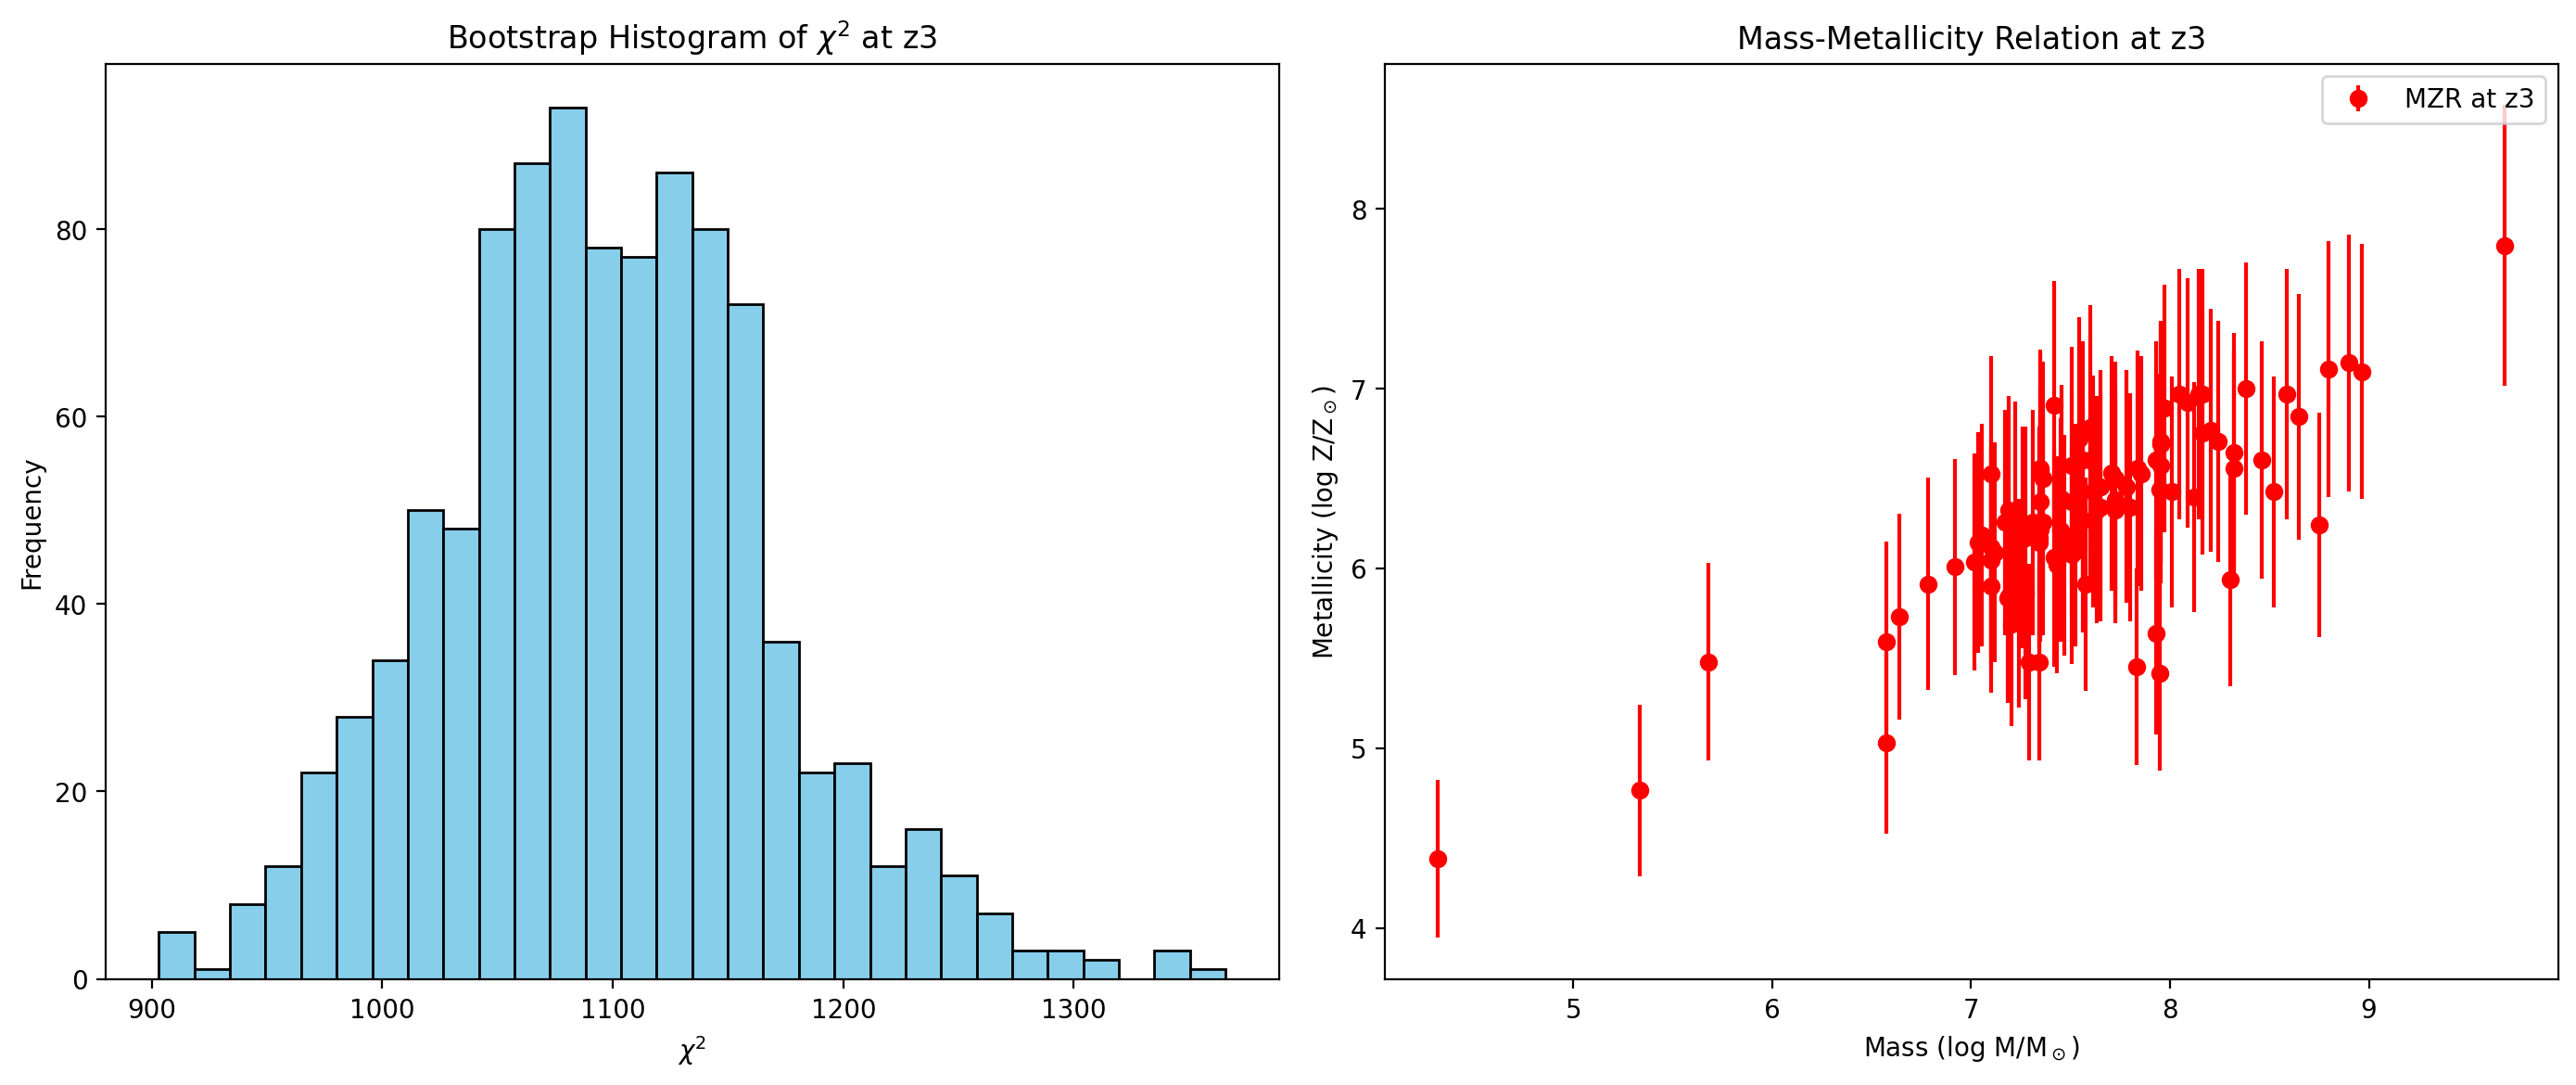

In [61]:

# Number of bootstrap iterations
n_boot = 1000
chi2_boot = np.zeros(n_boot)

# Loop through each redshift bin
for i, (z_key, (mZ, zZ)) in enumerate(redshift_bins.items()):
    # Assuming M_data, Z_data, Z_err are your mass, metallicity, and metallicity errors for each redshift bin
    M_data = mZ  # Replace with actual mass data
    Z_data = zZ  # Replace with actual metallicity data
    Z_err = 0.1 * Z_data  # Example error, replace with actual error model for each redshift

    # Bootstrap to calculate chi^2 distribution
    for j in range(n_boot):
        resample_idx = np.random.choice(len(M_data), size=len(M_data), replace=True)
        M_boot = M_data[resample_idx]
        Z_boot = Z_data[resample_idx]
        Z_err_boot = Z_err[resample_idx]
        
        chi2_boot[j] = np.sum(((Z_boot - Z_model(M_boot)) / Z_err_boot) ** 2)

    # Plotting for each redshift bin
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the histogram of chi^2 values (fit quality)
    ax[0].hist(chi2_boot, bins=30, color='skyblue', edgecolor='black')
    ax[0].set_title(f"Bootstrap Histogram of $\chi^2$ at {z_key}")
    ax[0].set_xlabel("$\chi^2$")
    ax[0].set_ylabel("Frequency")

    # Plot the MZR with heteroscedastic errors
    ax[1].errorbar(M_data, Z_data, yerr=Z_err, fmt='o', color='red', label=f'MZR at {z_key}')
    ax[1].set_title(f"Mass-Metallicity Relation at {z_key}")
    ax[1].set_xlabel("Mass (log M/M$_\odot$)")
    ax[1].set_ylabel("Metallicity (log Z/Z$_\odot$)")
    ax[1].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

<>:34: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\c'
<>:47: SyntaxWarning: invalid escape sequence '\o'
<>:48: SyntaxWarning: invalid escape sequence '\o'
<>:34: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\c'
<>:47: SyntaxWarning: invalid escape sequence '\o'
<>:48: SyntaxWarning: invalid escape sequence '\o'
/var/folders/9_/5x2g4jmx5fxb62v465flw5980000gp/T/ipykernel_98733/3073514788.py:34: SyntaxWarning: invalid escape sequence '\c'
  hist_vals, bin_edges, _ = ax[0].hist(chi2_boot, bins=bins, density=True, color='skyblue', edgecolor='black', label='Bootstrap $\chi^2$')
/var/folders/9_/5x2g4jmx5fxb62v465flw5980000gp/T/ipykernel_98733/3073514788.py:39: SyntaxWarning: invalid escape sequence '\c'
  ax[0].set_title(f"Bootstrap Histogram of $\chi^2$ at {z_key}")
/var/folders/9_/5x2g4jmx5fxb62v4

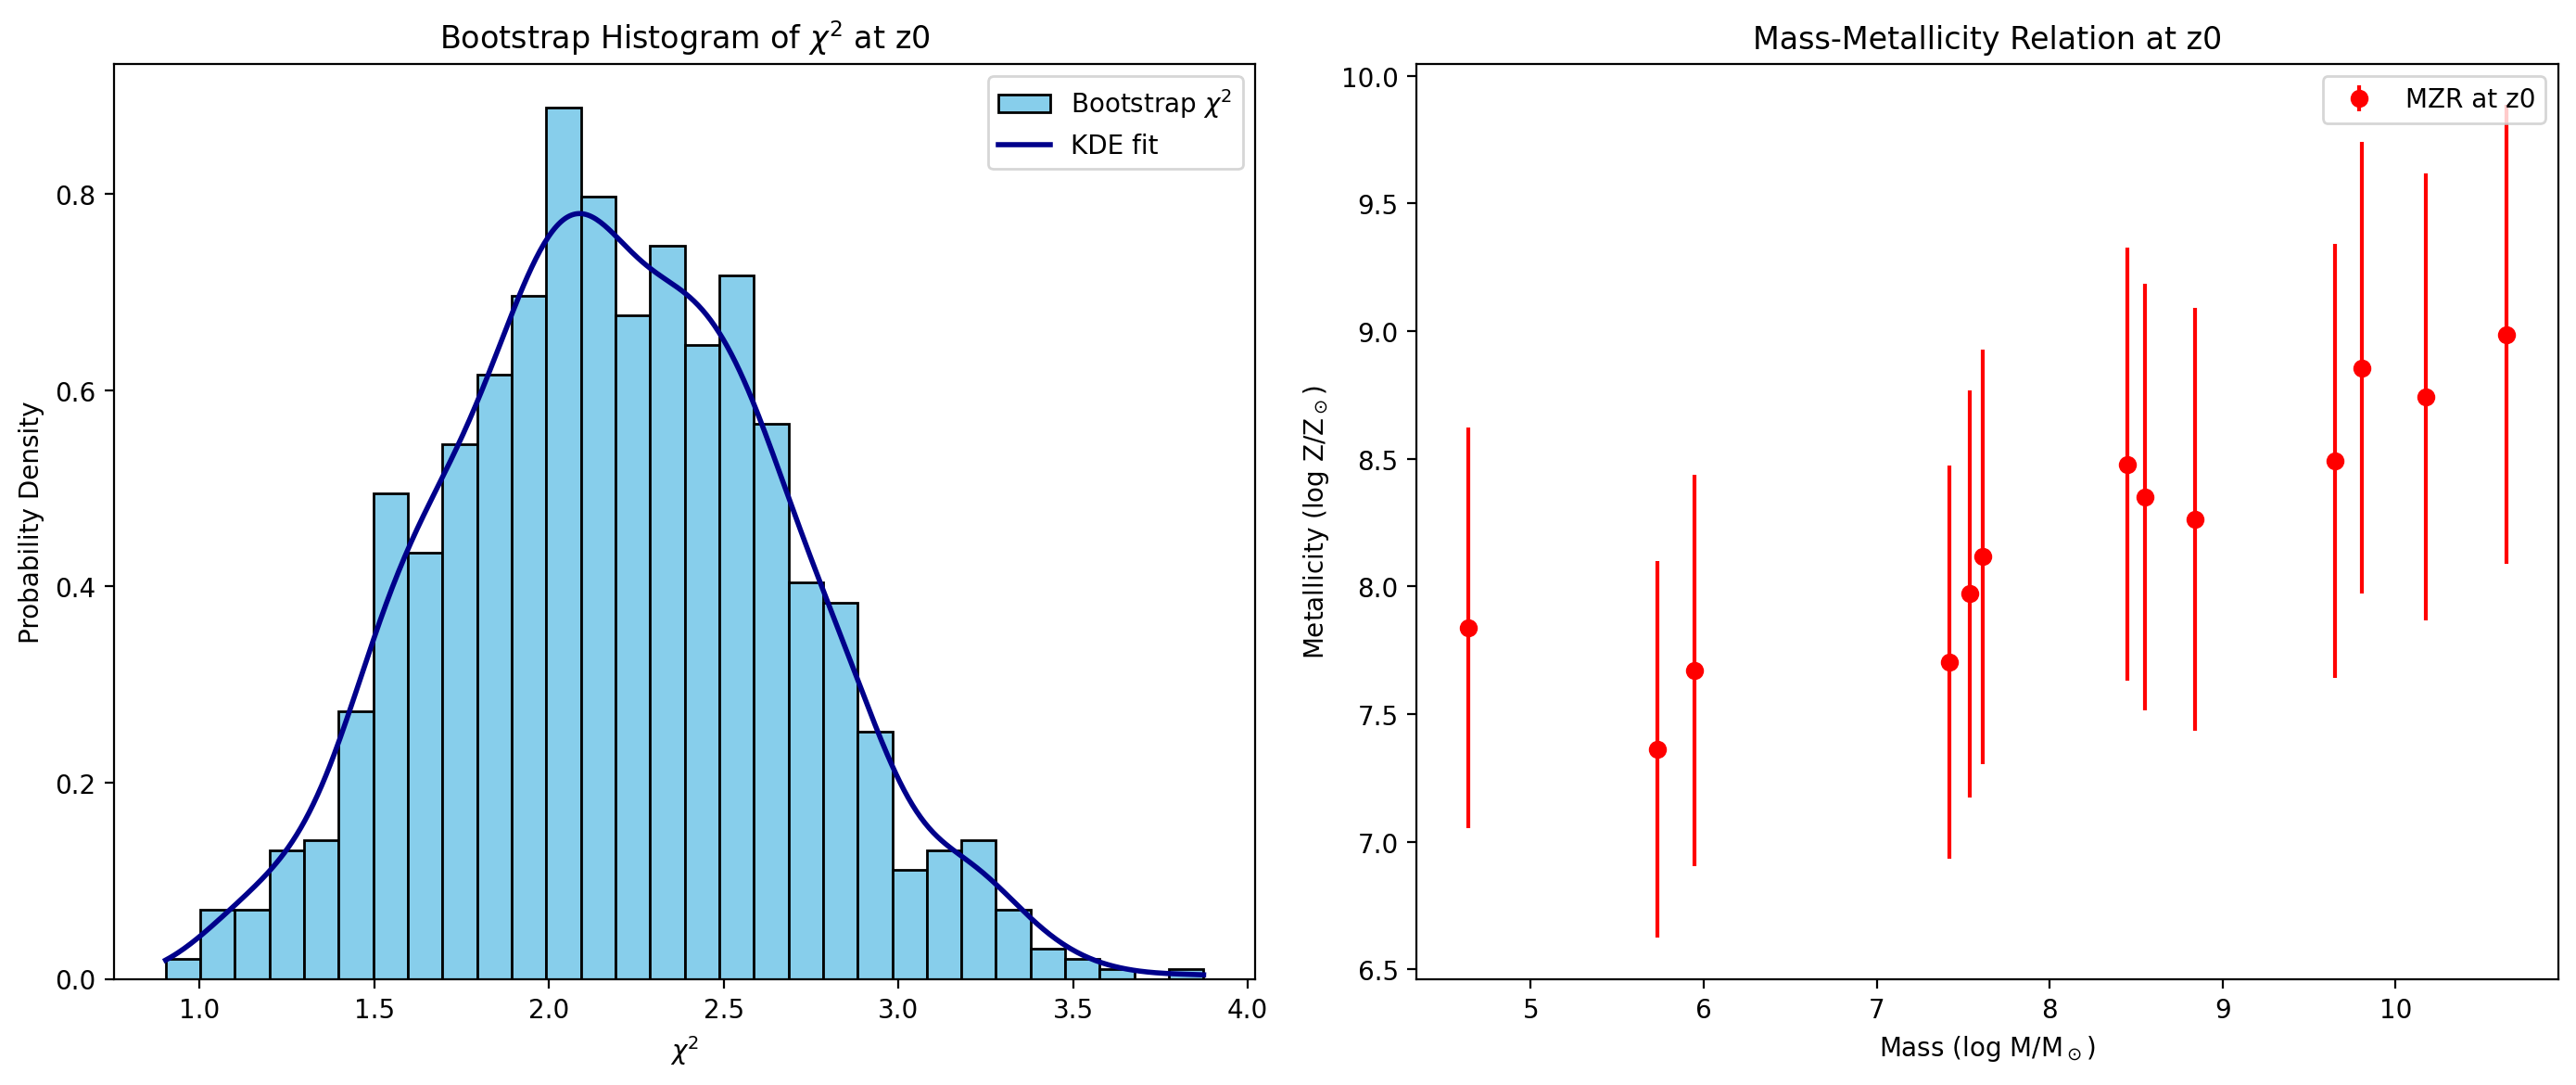

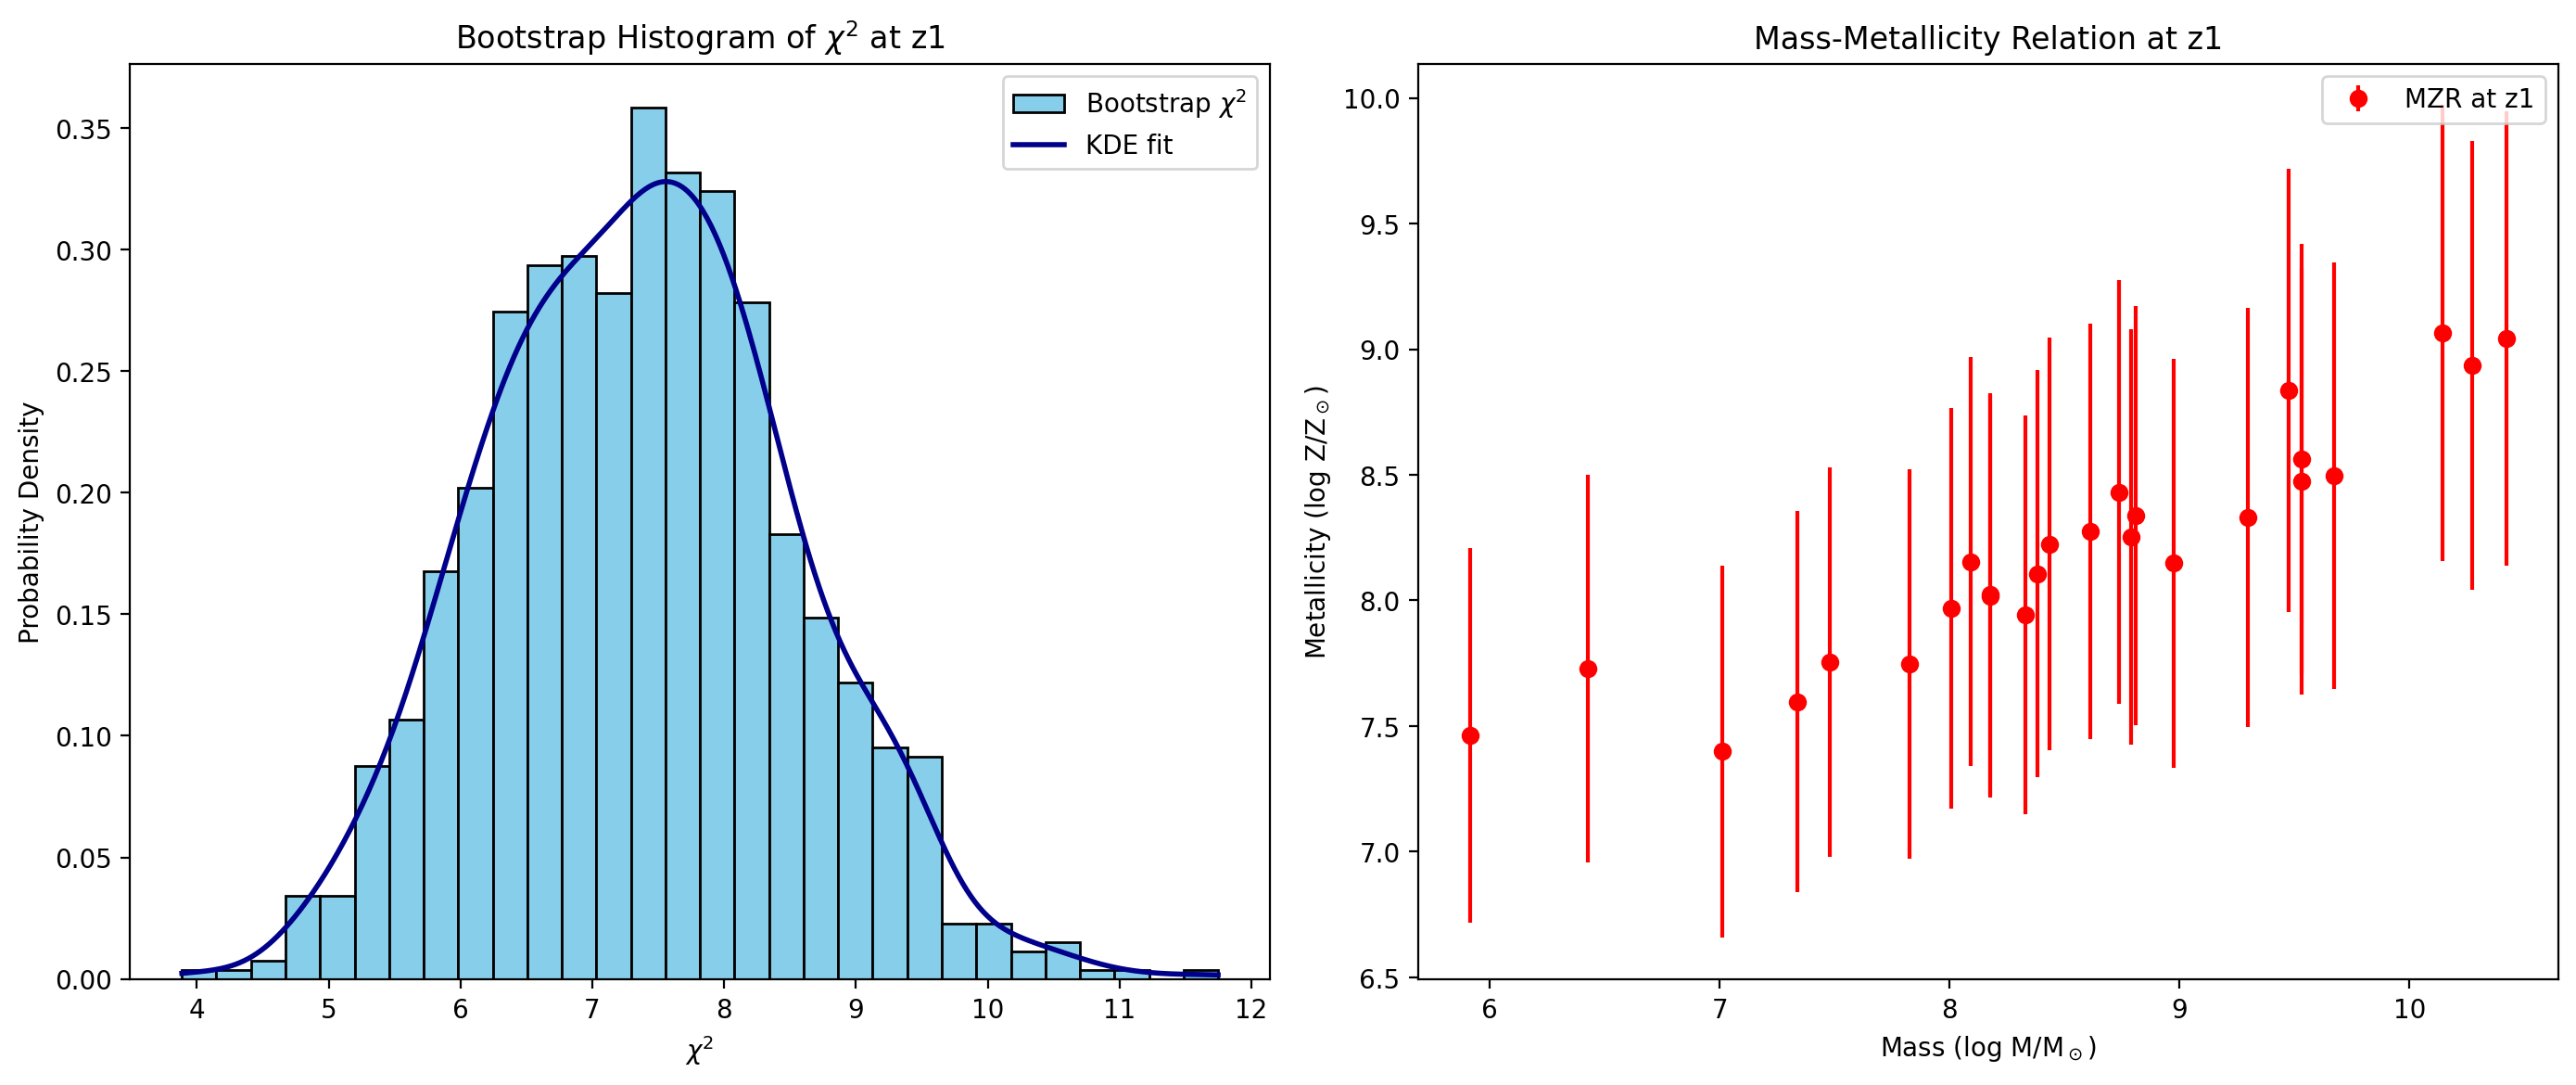

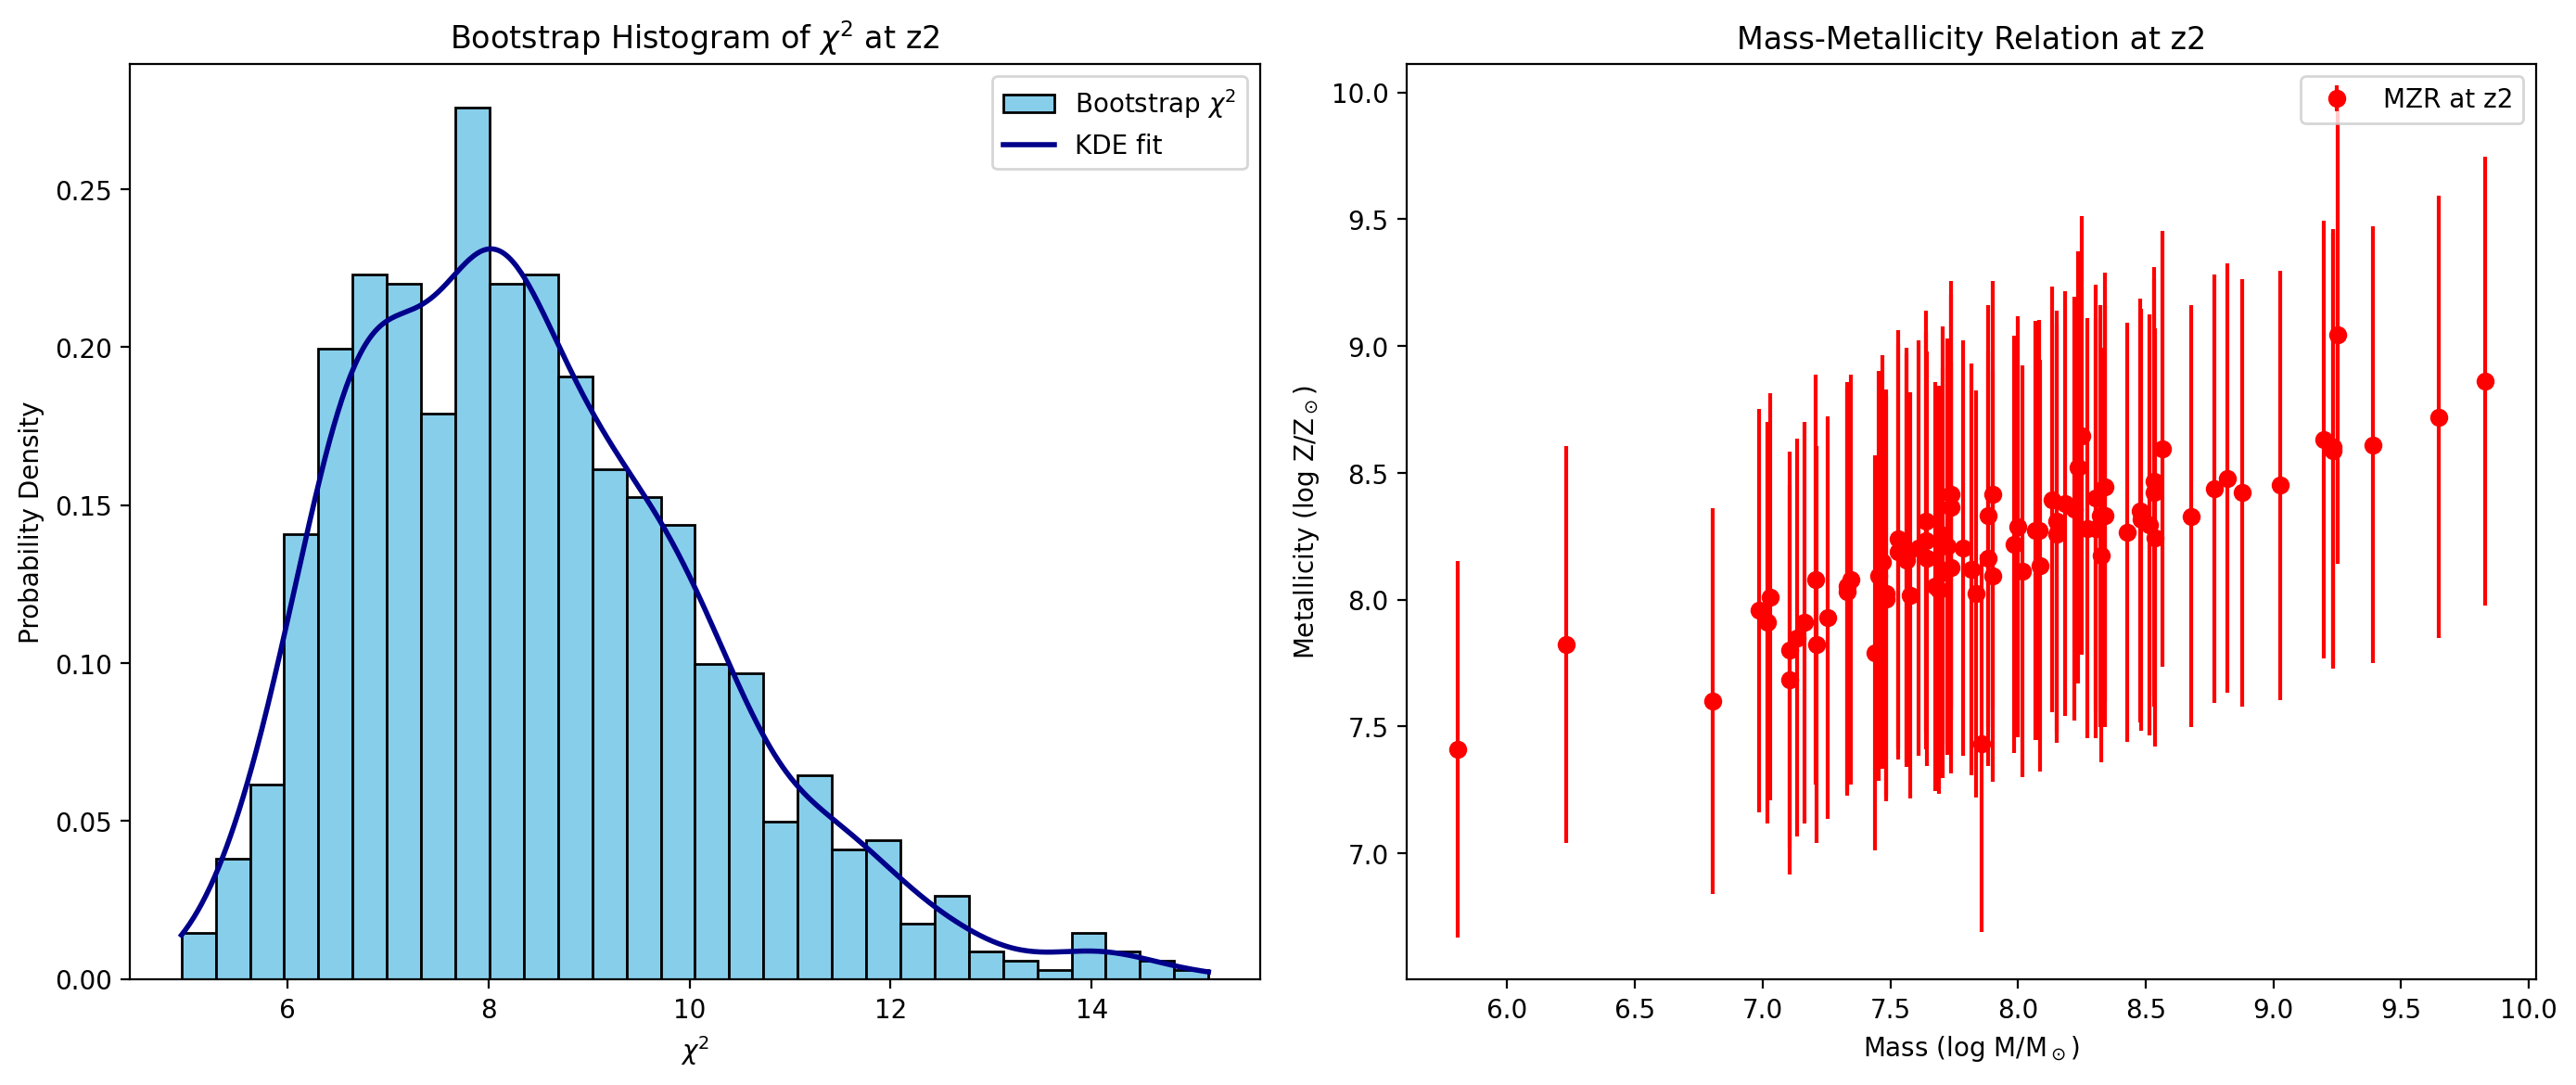

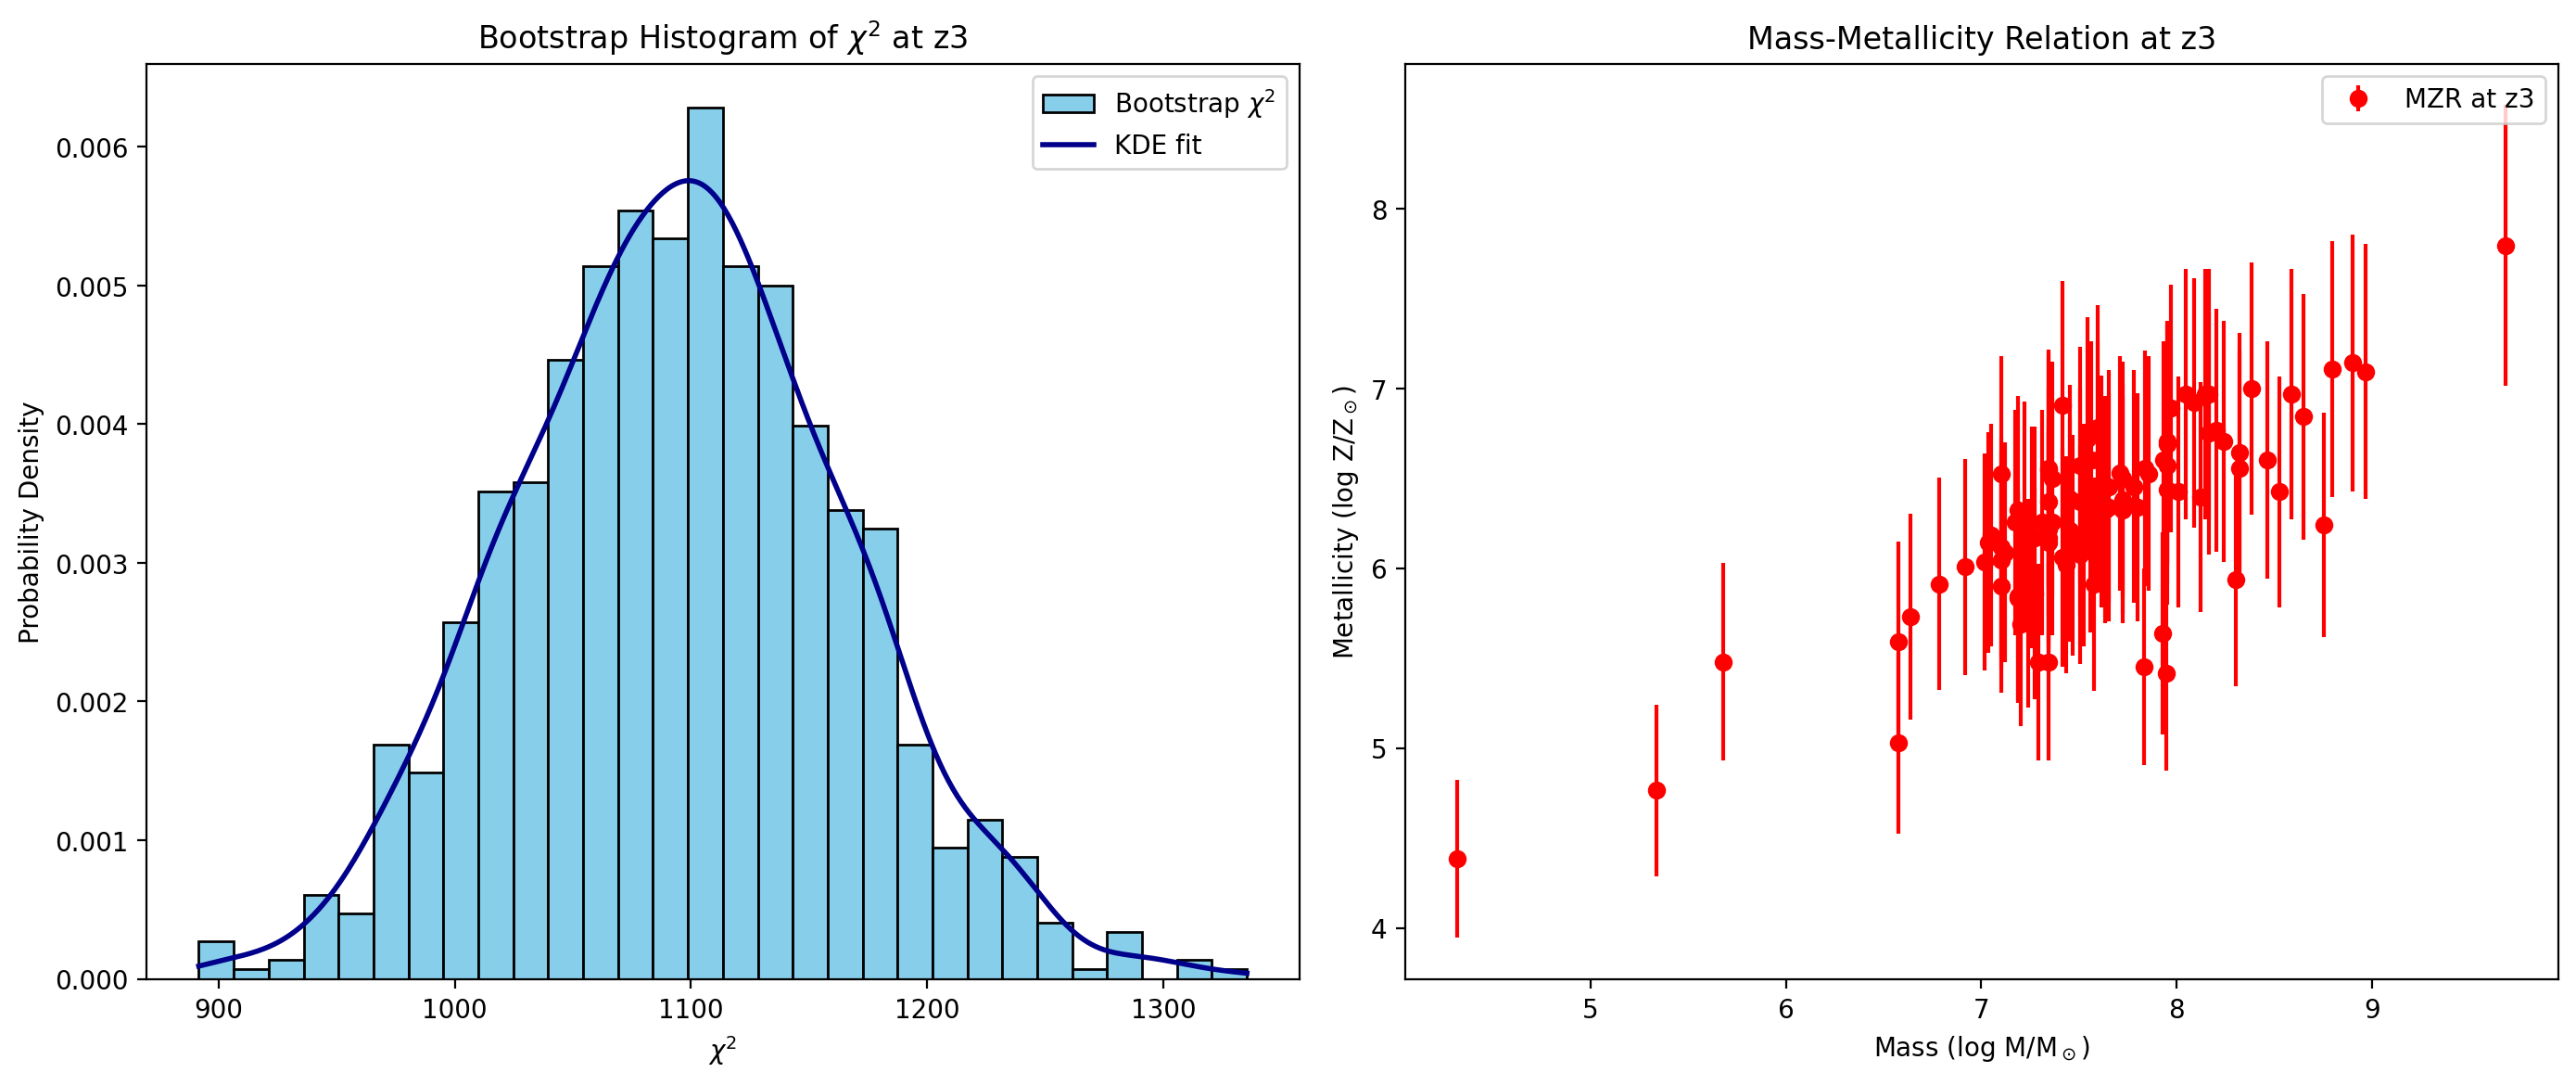

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pickle  # to optionally save the KDE fit

# Number of bootstrap iterations
n_boot = 1000
chi2_boot = np.zeros(n_boot)

# Loop through each redshift bin
for i, (z_key, (mZ, zZ)) in enumerate(redshift_bins.items()):
    # Assuming M_data, Z_data, Z_err are your mass, metallicity, and metallicity errors for each redshift bin
    M_data = mZ  # Replace with actual mass data
    Z_data = zZ  # Replace with actual metallicity data
    Z_err = 0.1 * Z_data  # Example error model

    # Bootstrap to calculate chi^2 distribution
    for j in range(n_boot):
        resample_idx = np.random.choice(len(M_data), size=len(M_data), replace=True)
        M_boot = M_data[resample_idx]
        Z_boot = Z_data[resample_idx]
        Z_err_boot = Z_err[resample_idx]
        
        chi2_boot[j] = np.sum(((Z_boot - Z_model(M_boot)) / Z_err_boot) ** 2)

    # Fit a KDE to the chi2_boot values
    kde = gaussian_kde(chi2_boot)

    # Plotting for each redshift bin
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Histogram of chi^2 values
    bins = 30
    hist_vals, bin_edges, _ = ax[0].hist(chi2_boot, bins=bins, density=True, color='skyblue', edgecolor='black', label='Bootstrap $\chi^2$')

    # Plot the PDF on top
    x_vals = np.linspace(min(chi2_boot), max(chi2_boot), 500)
    ax[0].plot(x_vals, kde(x_vals), color='darkblue', lw=2, label='KDE fit')
    ax[0].set_title(f"Bootstrap Histogram of $\chi^2$ at {z_key}")
    ax[0].set_xlabel("$\chi^2$")
    ax[0].set_ylabel("Probability Density")
    ax[0].legend()

    # Plot the Mass-Metallicity Relation with errors
    ax[1].errorbar(M_data, Z_data, yerr=Z_err, fmt='o', color='red', label=f'MZR at {z_key}')
    ax[1].set_title(f"Mass-Metallicity Relation at {z_key}")
    ax[1].set_xlabel("Mass (log M/M$_\odot$)")
    ax[1].set_ylabel("Metallicity (log Z/Z$_\odot$)")
    ax[1].legend()

    # Adjust layout and save the figure
    plt.tight_layout()
    fig.savefig(f"chi2_MZR_{z_key}.png", dpi=300)
    plt.show()

    # Optionally save the KDE fit for later use
    with open(f'kde_fit_{z_key}.pkl', 'wb') as f:
        pickle.dump(kde, f)


FileNotFoundError: [Errno 2] No such file or directory: '../homework/hw_data/hw7_data_1.npy'